- Why did f_cont miraculously improve even when I use the old transfer functions (xe over 11 points, rs over 51 points)

# Initialization

In [2]:
%load_ext autoreload
import sys
sys.path.append("..")

In [3]:
%autoreload

import numpy as np
import pickle

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [10,10]

import main

import darkhistory.physics as phys
import darkhistory.utilities as utils

from darkhistory.spec import spectools
from darkhistory.spec.spectrum import Spectrum
from darkhistory.spec.spectra import Spectra
from darkhistory.low_energy import lowE_electrons
from darkhistory.low_energy import lowE_deposition

from scipy.interpolate import interp1d
from scipy.interpolate import interp2d
from astropy.io import fits
from tqdm import tqdm_notebook as tqdm


In [4]:
xes = 0.5 + 0.5*np.tanh([-5., -4.1, -3.2, -2.3, -1.8, -1.4, -1, -.8, -0.65, -0.5, -.24, 0, .2, 0.4, .7, 1.3, 2.2, 3.1, 4])
xes

array([4.53978687e-05, 2.74578156e-04, 1.65880108e-03, 9.95180187e-03,
       2.65969936e-02, 5.73241759e-02, 1.19202922e-01, 1.67981615e-01,
       2.14165017e-01, 2.68941421e-01, 3.82252125e-01, 5.00000000e-01,
       5.98687660e-01, 6.89974481e-01, 8.02183889e-01, 9.30861580e-01,
       9.87871565e-01, 9.97974680e-01, 9.99664650e-01])

In [30]:
xes = 0.5 + 0.5*np.tanh([-5., -4.1, -3.2, -2.3, -1.4, -0.5, 0.4, 1.3, 2.2, 3.1, 4])
  
direc_arr = "/home/gridgway/Downloads/complete/"

(highengphot_tf_interp0,
     lowengphot_tf_interp0,
     lowengelec_tf_interp0,
     highengdep_interp0,
     CMB_engloss_interp0
    ) = main.load_trans_funcs(direc_arr, xes, string_arr=string_arr, inverted=True)

Loading transfer functions...
Loaded high energy photons...
Low energy photons...
Low energy electrons...
high energy deposition.

CMB losses.

Padding tflists with zeros...
high energy photons...
low energy photons...
low energy electrons...

high energy deposition.

CMB losses.

Generating TransferFuncInterp objects for each tflist...
noninterp
noninterp
noninterp
Done.



In [5]:
%autoreload
direc = '/Users/hongwan/Dropbox (MIT)/Photon Deposition/tflists/complete/'
direc = '/home/gridgway/Downloads/complete/'
direc = '/home/gridgway/Desktop/DH_Data/'

# xes = 0.5 + 0.5*np.tanh([-5., -4.1, -3.2, -2.3, -1.4, -0.5, 0.4, 1.3, 2.2, 3.1, 4])

# xes = 0.5 + 0.5*np.tanh([-5., -4.1, -3.2, -2.3, -1.4, -.8, -0.5, -.24, 0, .2, 0.4, .7, 1.3, 2.2, 3.1, 4])
# xes = np.array([.99,.999])
# xes = None
# string_arr = ["_standard_xe_xHe"]

# xes = np.array(
#     [0.5 + 0.5*np.tanh([-5., -4.1, -3.2, -2.3, -1.4, -.8, -0.5, -.24, 0, .2, 0.4, .7, 1.3, 2.2, 3.1, 4]), None]
# )
# string_arr = ["", "_standard_xe_xHe"]

# xes = np.array(
#     [0.5 + 0.5*np.tanh([-5., -4.1, -3.2, -2.3, -1.4, -0.5, 0.4, 1.3, 2.2, 3.1, 4]),
#      0.5 + 0.5*np.tanh([-5., -4.1, -3.2, -2.3, -1.4, -.8, -0.5, -.24, 0, .2, 0.4, .7, 1.3, 2.2, 3.1, 4]), 
# #      None]
#      np.array([.99,.999])]
# )
# direc_arr = ["/home/gridgway/Downloads/complete/",
#              "/home/gridgway/Desktop/DH_Data/",
#              "/home/gridgway/Desktop/DH_Data/"]
# # string_arr = ["", "", "_standard_xe_xHe"]
# string_arr = ["", "", "_pre1700"]

# direc_arr = [direc, direc]
# xes = np.array([
#     0.5 + 0.5*np.tanh([-5., -4.1, -3.2, -2.3, -1.8, -1.4, -1, -.8, -0.65, -0.5, -.24, 0, .2, 0.4, .7, 1.3, 2.2, 3.1, 4]),
#     None]
# )
# string_arr = ["_post1700_xHe0", "_standard_xe_xHe"]

(highengphot_tf_interp,
     lowengphot_tf_interp,
     lowengelec_tf_interp,
     highengdep_interp,
     CMB_engloss_interp
    ) = main.load_trans_funcs(direc_arr, xes, string_arr=string_arr, inverted=True)

Loading transfer functions...
Loaded high energy photons...
Low energy photons...
Low energy electrons...
high energy deposition.

CMB losses.

Padding tflists with zeros...
high energy photons...
low energy photons...
low energy electrons...

high energy deposition.

CMB losses.

Generating TransferFuncInterp objects for each tflist...
noninterp
noninterp
noninterp
Loading transfer functions...
Loaded high energy photons...
Low energy photons...
Low energy electrons...
high energy deposition.

CMB losses.

Padding tflists with zeros...
high energy photons...
low energy photons...
low energy electrons...

high energy deposition.

CMB losses.

Generating TransferFuncInterp objects for each tflist...
noninterp
noninterp
noninterp
Done.



In [4]:
ics_thomson_ref_tf=pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tflists/ics/ics_thomson_ref_tf.raw", "rb")) 
ics_rel_ref_tf=pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tflists/ics/ics_rel_ref_tf.raw", "rb"))
engloss_ref_tf=pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tflists/ics/engloss_ref_tf.raw", "rb"))

Load the standard ionization and thermal histories.

In [7]:
soln = pickle.load(open("../darkhistory/history/std_soln.p", "rb"))
xe_std  = interp1d(soln[0,:], soln[2,:])
Tm_std = interp1d(soln[0,:], soln[1,:])

# Choice of Mass Parameter and Channel

In [67]:
mDM = 4e7

chan = 'phot'

# Load Reference Files

## Load Reference Spectra

Load the file containing the reference spectra.

In [68]:
direc = '/home/gridgway/Desktop/DH_Data/'
if mDM == 4e12:

    hdul = fits.open(
        direc
        +'tf_'+chan+'_z_3.000E+03_nstep_6622_logE_1.230E+01_xe_0.000E+00.fits'
    )

elif mDM == 4e5:
#     hdul = fits.open(
#         direc
#         +'pre1700_standard_xe_xHe/tf_z_3.000E+03_nstep_593_logE_5.301E+00_xe_0.000E+00.fits'
#     )
#     hdul = fits.open(
#         direc
#         +'tf_'+chan+'_z_3.000E+03_nstep_6622_logE_5.301E+00_xe_0.000E+00.fits'
#     )
    hdul = fits.open(
        direc
        +'pre1700_standard_xe_xHe/tf_z_3.000E+03_nstep_6622_logE_5.301E+00_xe_0.000E+00.fits'
    )
    
    
elif mDM == 6e6:
    hdul = fits.open(
        direc
        +'tf_'+chan+'_z_3.000E+03_nstep_6622_logE_6.477E+00_xe_0.000E+00.fits'
    )
elif mDM == 4e7:
#     hdul = fits.open(
#         direc
#         +'pre1700_standard_xe_xHe/tf_z_3.000E+03_nstep_593_logE_7.301E+00_xe_0.000E+00.fits'
#     )
    hdul = fits.open(
        direc
        +'pre1700_standard_xe_xHe/tf_z_3.000E+03_nstep_6622_logE_7.301E+00_xe_0.000E+00.fits'
    )
elif mDM == 4e9:
    hdul = fits.open(
        direc
        +'pre1700_standard_xe_xHe/tf_z_3.000E+03_nstep_593_logE_9.301E+00_xe_0.000E+00.fits'
    )
elif mDM == 4e11:
    hdul = fits.open(
        direc
        +'pre1700_standard_xe_xHe/tf_z_3.000E+03_nstep_593_logE_1.130E+01_xe_0.000E+00.fits'
    )
    

else:
    raise TypeError('invalid mDM.')
    
data = hdul[1].data

idl_photonspectrum = data.field('photonspectrum')[0]
idl_lowengphot = data.field('lowengphot')[0]
idl_lowengelec = data.field('lowengelec')[0]
idl_energy = data.field('energy')[0]
idl_eleceng = data.field('eleceng')[0]
idl_redshift = data.field('redshift')[0]
idl_cmblosstable = data.field('cmblosstable')[0]
idl_highengdep = data.field('highdeposited_grid')[0]

idl_bin_width = np.diff(np.log(spectools.get_bin_bound(data.field('energy')[0]))) * idl_energy
idl_elec_bin_width = np.diff(np.log(spectools.get_bin_bound(data.field('eleceng')[0]))) * idl_eleceng

hdul.close()

1653.0338369740207 4.169625601457838e-09


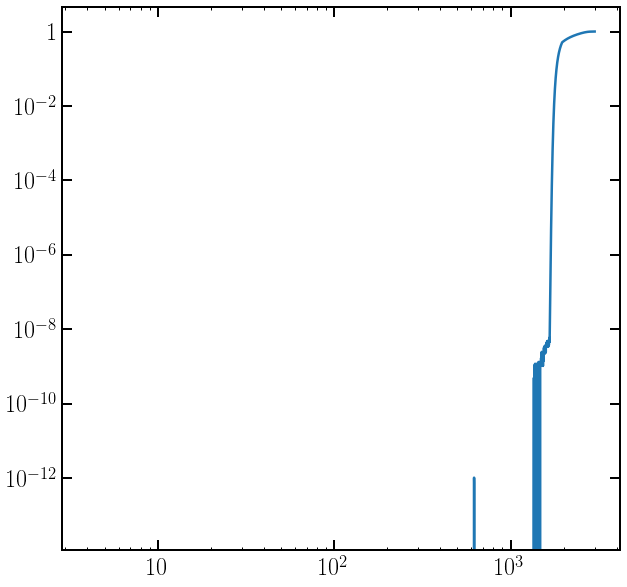

In [69]:
print(idl_redshift[597-1], data.field('heionfraction')[0][597])

plt.figure()
ax = plt.gca()
ax.loglog()
plt.plot(idl_redshift, data.field('heionfraction')[0])

In [286]:
data.columns.info()

name:
    ['DEPOSITEDENERGY', 'DEP_PROMPT', 'DEP_HIGHENERGY', 'DEP_CASCADES', 'DEP_PHOTOION', 'DEP_COMPTON', 'DEP_LOW', 'DEP_LOW60', 'LOWERBOUND', 'REDSHIFTLOSS', 'PHOTONSPECTRUM', 'COMPTON_ELEC_SPEC', 'HIONFRACTION', 'HEIONFRACTION', 'ENERGY', 'ELECENG', 'REDSHIFT', 'ENERGYCONSERVATION', 'H0', 'OMEGA_M', 'OMEGA_B', 'OMEGA_RAD', 'OMEGA_LAM', 'T_CMB0', 'YHE', 'HUBBLERATE', 'MWIMP', 'CHANNEL', 'SIGMAV', 'ANNRATE', 'IONHIST_VERSION', 'HIGHDEPOSITED', 'HIGHDEP_PROMPT', 'HIGHDEP_HIGHENERGY', 'HIGHDEP_CASCADES', 'HIGHDEP_PHOTOION', 'HIGHDEP_COMPTON', 'HIGHDEP_LOW', 'HIGHDEP_LOW60', 'DEPOSITIONPARTITIONVALS', 'LOWENGELEC', 'LOWENGPHOT', 'LOWENGPHOT_DEPOSITED', 'LOWENGPHOT_CONT', 'CMBLOSSTABLE', 'HIGHDEPOSITED_GRID', 'HIGHDEP_PROMPT_GRID', 'HIGHDEP_HIGHENERGY_GRID', 'HIGHDEP_CASCADES_GRID', 'HIGHDEP_PHOTOION_GRID', 'HIGHDEP_COMPTON_GRID', 'HIGHDEP_LOW_GRID', 'HIGHDEP_LOW60_GRID', 'LOWENGPHOT_ELEMENTGRID', 'LOWENGPHOT_ELEMENTGRID_DEPOSITED']
format:
    ['593D', '593D', '593D', '593D', '593D', 

## Load Reference $f(z)$ (Direct from IDL)

Load the file containing the $f(z)$ calculations

In [70]:
if mDM == 4e12:

    hdul = fits.open(
        direc
        +'calculated_fractions_'+chan+'_logE_1.230E+01.fits'
    )
    
elif mDM == 4e5:
#     hdul = fits.open(
#         direc
#         +'pre1700_standard_xe_xHe/calculated_fractions_logE_5.301E+00.fits'
#     )
#     hdul = fits.open(
#         direc
#         +'calculated_fractions_'+chan+'_logE_5.301E+00.fits'
#     )
    hdul = fits.open(
            direc
            +'calculated_fractions_logE_5.301E+00_standard_xe_xHe.fits'
        )
    
elif mDM == 6e6:
    hdul = fits.open(
        direc
        +'calculated_fractions_'+chan+'_logE_6.477E+00.fits'
    )
elif mDM == 3e6:
    hdul = fits.open(
        direc
        +'calculated_fractions_'+chan+'_logE_6.477E+00.fits'
    )
elif mDM == 4e7:
#     hdul = fits.open(
#         direc
#         +'pre1700_standard_xe_xHe/calculated_fractions_logE_7.301E+00.fits'
#     )
    hdul = fits.open(
            direc
            +'calculated_fractions_logE_7.301E+00_standard_xe_xHe.fits'
        )
elif mDM == 4e9:
    hdul = fits.open(
        direc
        +'pre1700_standard_xe_xHe/calculated_fractions_logE_9.301E+00.fits'
    )
elif mDM == 4e11:
    hdul = fits.open(
        direc
        +'pre1700_standard_xe_xHe/calculated_fractions_logE_1.130E+01.fits'
    )

else:
    raise TypeError('invalid mDM.')

data = hdul[1].data

f_idl_low  = data.field('loweng_deposition_fractions')[0]
f_idl_high = data.field('higheng_deposition_fractions')[0]
xe_idl     = data.field('xH')[0]


f_idl = f_idl_low + f_idl_high


hdul.close()

## Load Reference $f(z)$ (from Mathematica)

Load the $f(z)$ values from Mathematica.

In [15]:
direc = '/Users/hongwan/Dropbox (MIT)/'
direc = '/home/gridgway/Dropbox (MIT)/'
fz_elec_decay = np.loadtxt(direc+'21cm_pwave/TLA_code/fz_electron_decay.dat', delimiter=',')

log10rs  = fz_elec_decay[0:70, 1]
log10eng = fz_elec_decay[0:2800:70, 0] 

log10f_elec_decay = {
    'H_ion':   np.transpose(np.reshape(fz_elec_decay[0:2800,2], (40,70))),
    'He_ion':  np.transpose(np.reshape(fz_elec_decay[2800:5600,2], (40,70))),
    'H_exc':   np.transpose(np.reshape(fz_elec_decay[5600:8400,2], (40,70))),
    'heating': np.transpose(np.reshape(fz_elec_decay[8400:11200,2], (40,70))),
    'cont':    np.transpose(np.reshape(fz_elec_decay[11200:14000,2], (40,70))) 
}

fz_phot_decay = np.loadtxt(direc+'21cm_pwave/TLA_code/fz_photon_decay.dat', delimiter=',')

log10rs  = fz_phot_decay[0:70, 1]
log10eng = fz_phot_decay[0:2800:70, 0] 

log10f_phot_decay = {
    'H_ion':   np.transpose(np.reshape(fz_phot_decay[0:2800,2], (40,70))),
    'He_ion':  np.transpose(np.reshape(fz_phot_decay[2800:5600,2], (40,70))),
    'H_exc':   np.transpose(np.reshape(fz_phot_decay[5600:8400,2], (40,70))),
    'heating': np.transpose(np.reshape(fz_phot_decay[8400:11200,2], (40,70))),
    'cont':    np.transpose(np.reshape(fz_phot_decay[11200:14000,2], (40,70)))
}

In [16]:
log10f_tmp = log10f_phot_decay

def f_H_ion(rs, Einj):
    interp_func = interp2d(log10eng, log10rs, log10f_tmp['H_ion'])
    return 10**interp_func(np.log10(Einj), np.log10(rs))[0]

def f_He_ion(rs, Einj):
    interp_func = interp2d(log10eng, log10rs, log10f_tmp['He_ion'])
    return 10**interp_func(np.log10(Einj), np.log10(rs))[0]

def f_H_exc(rs, Einj):
    interp_func = interp2d(log10eng, log10rs, log10f_tmp['H_exc'])
    return 10**interp_func(np.log10(Einj), np.log10(rs))[0]

def f_heating(rs, Einj):
    interp_func = interp2d(log10eng, log10rs, log10f_tmp['heating'])
    return 10**interp_func(np.log10(Einj), np.log10(rs))[0]

def f_cont(rs, Einj):
    interp_func = interp2d(log10eng, log10rs, log10f_tmp['cont'])
    return 10**interp_func(np.log10(Einj), np.log10(rs))[0]

# `DarkHistory` Evaluation, $\chi \to \gamma \gamma$

In [17]:
%autoreload
eleceng = lowengelec_tf_interp.eng
photeng = lowengphot_tf_interp.eng

# Due to configuration issues, specifying mwimp=2e12 with tau = 1e25
# in the main code actually translates into an *actual* mDM=4e12, with
# tau = 0.5e25.
# mDM = 4e12
# mDM = 4e5
tau = 0.5e25

# kinetic energy!
# elec_spec_init = spectools.rebin_N_arr(np.array([2]), np.array([(mDM - 2*phys.me)/2]), eleceng)
# elec_spec_init.rs = 3000

# phot_spec_init = Spectrum(photeng, np.zeros_like(photeng), rs = 3000)

# find the uppermost bin to perform the injection.
# inject mDM/2/eng_delta_inj particles.
injE = photeng[photeng < mDM/2][-1]

phot_spec_init = spectools.rebin_N_arr(np.array([2*mDM/2/injE]), np.array([injE]), photeng)
phot_spec_init.rs = 3000

elec_spec_init = Spectrum(eleceng, np.zeros_like(eleceng), rs=3000)

if elec_spec_init.spec_type == 'dNdE':
    elec_spec_init.switch_spec_type()
if phot_spec_init.spec_type == 'dNdE':
    phot_spec_init.switch_spec_type()
    
def rate_func_N(rs):
    return phys.rho_DM*rs**3/tau/mDM

def rate_func_eng(rs):
    return phys.rho_DM*rs**3/tau

# Evolve according to xe provided by the IDL file.

xe_idl_func = interp1d(idl_redshift, xe_idl, bounds_error=False, fill_value=(xe_idl[-1], xe_idl[0]))

b_4e12 = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_N, rate_func_eng, 4,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
    highengdep_interp, CMB_engloss_interp, ics_only=False, separate_higheng=True,
#     ics_thomson_ref_tf=ics_thomson_ref_tf, ics_rel_ref_tf=ics_rel_ref_tf, engloss_ref_tf=engloss_ref_tf,
    coarsen_factor=1,std_soln=True, xe_func=xe_idl_func, user=None, verbose=False, use_tqdm=True
)

# Vector of dt steps.
rs_vec = b_4e12[2].rs
dt_vec = 0.001/phys.hubble(rs_vec)

In [435]:
#CMB_engloss_interp.rs_nodes[1] = 1653.35375194

In [500]:
#highengphot_tf_interp.rs_nodes[0]

911.1927743417696

# $f(z)$ Calculation Comparisons - PASSED

## `DarkHistory` Calculation

First, we will compare the $f(z)$ computed by `DarkHistory` with the values obtained by Tracy, using the same spectral input from the IDL produced reference file, but running `lowE_deposition.compute_fs` to obtain the corresponding values of $f(z)$. 

We can call MEDEA_interp with either two 1D interpolations, or one 2D interpolation, but the actual result changes very little.

In [18]:
# Create the MEDEA interpolation object. Default is 2D
MEDEA_interp = lowE_electrons.make_interpolator()

In [71]:
rs_vec=idl_redshift

In [72]:
# Vector of dt steps.
dt_vec = 0.001/phys.hubble(rs_vec)

# Choose the xe to use: from xe_std, or from the IDL file.
# std_xe_vec = xe_std(rs_vec)
std_xe_vec = xe_idl

# Store x_input in the correct format
x_input = np.transpose([1-std_xe_vec, np.zeros_like(std_xe_vec), np.zeros_like(std_xe_vec)])

# Calculate rate_input for input to compute_fs
rate_input = rate_func_eng(rs_vec)

# Convert the IDL spectra to Spectra objects.
ref_lowengelec = Spectra(idl_lowengelec*idl_elec_bin_width, eng=idl_eleceng, rs=rs_vec, spec_type='N')
ref_lowengphot = Spectra(idl_lowengphot*idl_bin_width, eng=idl_energy, rs=rs_vec, spec_type='N')

# Empty container for f's
f_arr_DH_low = np.outer(np.zeros_like(rs_vec),np.zeros(5))
f_arr_DH_high = np.outer(np.zeros_like(rs_vec),np.zeros(5))

# Loop compute_fs over the spectra produced.
for i, (elec_spec, phot_spec, x, dE_dVdt_inj, dt, highengdep, cmbloss) in tqdm(
    enumerate(
        zip(
            ref_lowengelec, ref_lowengphot, x_input, rate_input, dt_vec, 
            np.transpose(idl_highengdep), idl_cmblosstable
        )
    ),   
    total = idl_cmblosstable.shape[0] # Just for tqdm
) :
    f = lowE_deposition.compute_fs(
        MEDEA_interp, elec_spec, phot_spec, x, dE_dVdt_inj, dt, highengdep, cmbloss, method="old", 
        separate_higheng=True
    )
    f_arr_DH_low[i]  += f[0]
    f_arr_DH_high[i] += f[1]
                 

In [73]:
tmpInd=len(b_4e12[2].rs)-1

In [74]:
rs_vec = b_4e12[2].rs[:tmpInd]

## $f(z)$ Plots - Absolute Comparison

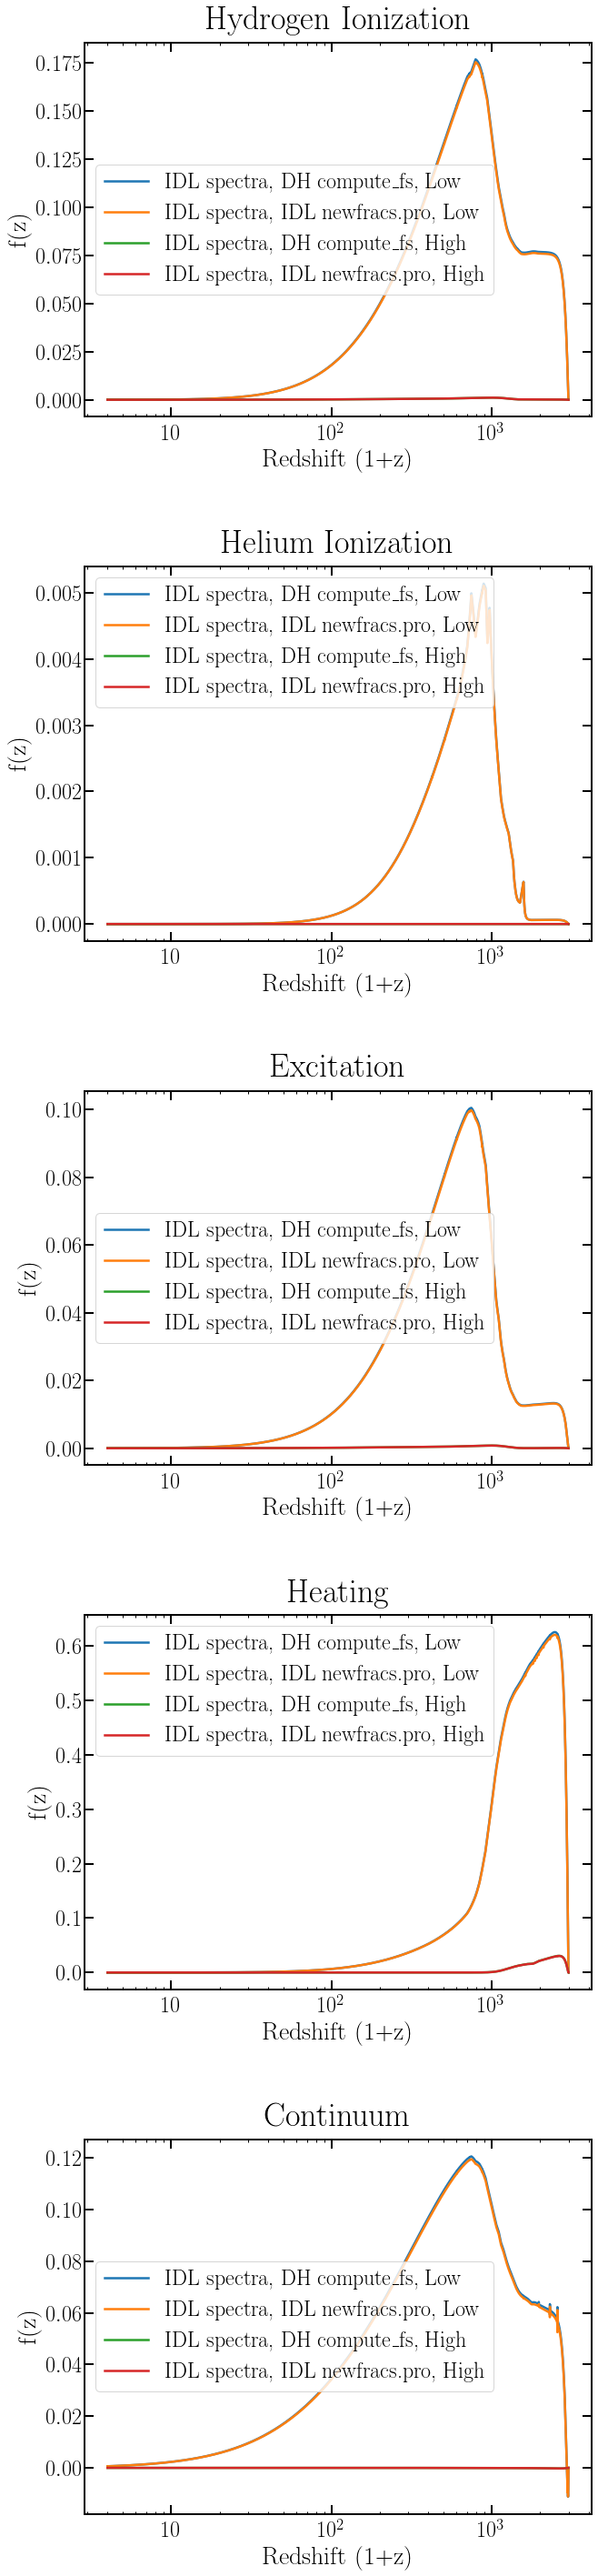

In [75]:
%autoreload 2
plt.figure(figsize=(10,50))
plt.subplots_adjust(hspace=.4)

for i in range(5):
    plt.subplot(5,1,i+1)
    ax = plt.gca()
    ax.set_xscale('log')
#     ax.set_yscale('log')
    plt.xlabel('Redshift (1+z)')
    plt.ylabel('f(z)')
    if i == 0:
        plt.title('Hydrogen Ionization')
    elif i == 1:
        plt.title('Helium Ionization')
    elif i == 2:
        plt.title('Excitation')
    elif i == 3:
        plt.title('Heating')
    elif i == 4:
        plt.title('Continuum')
    plt.plot(rs_vec, f_arr_DH_low[:tmpInd,i], label='IDL spectra, DH compute\_fs, Low')
    plt.plot(rs_vec, f_idl_low[i,:tmpInd], label='IDL spectra, IDL newfracs.pro, Low')
    plt.plot(rs_vec, f_arr_DH_high[:tmpInd,i], label='IDL spectra, DH compute\_fs, High')
    plt.plot(rs_vec, f_idl_high[i,:tmpInd], label='IDL spectra, IDL newfracs.pro, High')
    plt.legend()

## $f(z)$ Plots - Relative Comparison

/home/gridgway/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/home/gridgway/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


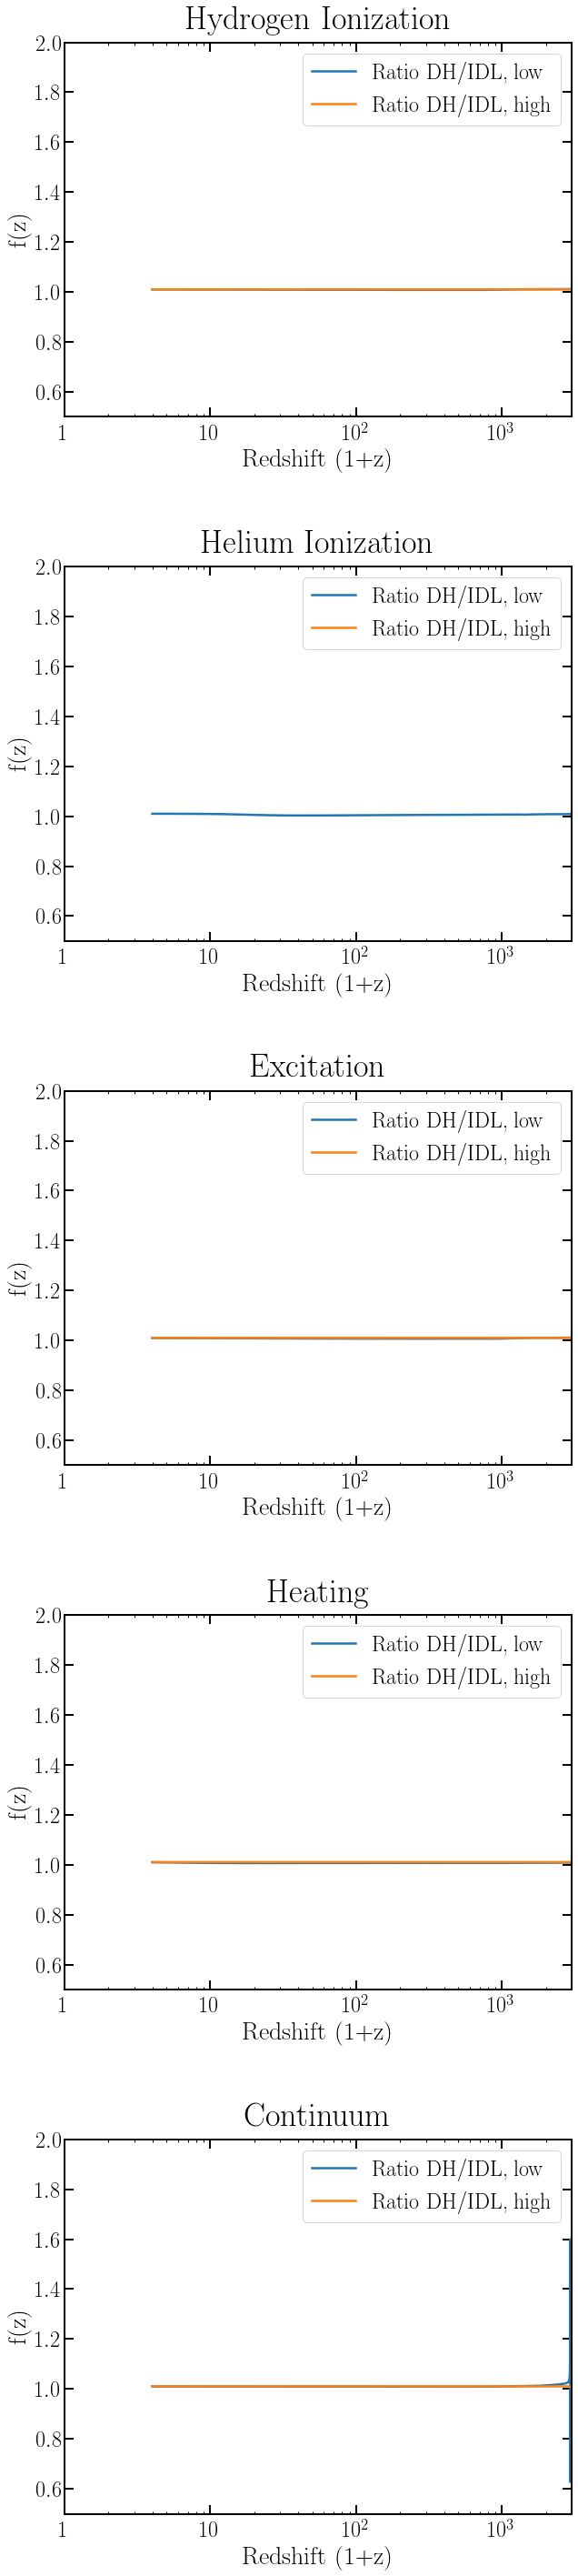

In [76]:
plt.figure(figsize=(10,50))
plt.subplots_adjust(hspace=.4)

for i in range(5):
    plt.subplot(5,1,i+1)
    ax = plt.gca()
    ax.set_xscale('log')
#     ax.set_yscale('log')
    plt.xlabel('Redshift (1+z)')
    plt.ylabel('f(z)')
    if i == 0:
        plt.title('Hydrogen Ionization')
    elif i == 1:
        plt.title('Helium Ionization')
    elif i == 2:
        plt.title('Excitation')
    elif i == 3:
        plt.title('Heating')
    elif i == 4:
        plt.title('Continuum')
        
    plt.axis([1, 3000, 0.5, 2])
    plt.plot(rs_vec, f_arr_DH_low[:tmpInd,i]/f_idl_low[i,:tmpInd], label='Ratio DH/IDL, low')
    plt.plot(rs_vec, f_arr_DH_high[:tmpInd,i]/f_idl_high[i,:tmpInd], label='Ratio DH/IDL, high')
    
    plt.legend()

## Comments

To get agreement, two important things must be done. 

* The photon deposition method must be in agreement with the IDL method, which does not sum over partial bins. 
* The ionization history must be identical. 

Without these two points, there are large deviations at the start (excitation can be as much as 20% larger) as well as during recombination.

# `main.evolve` Tests

## Spectrum Comparison

149.36120510359171


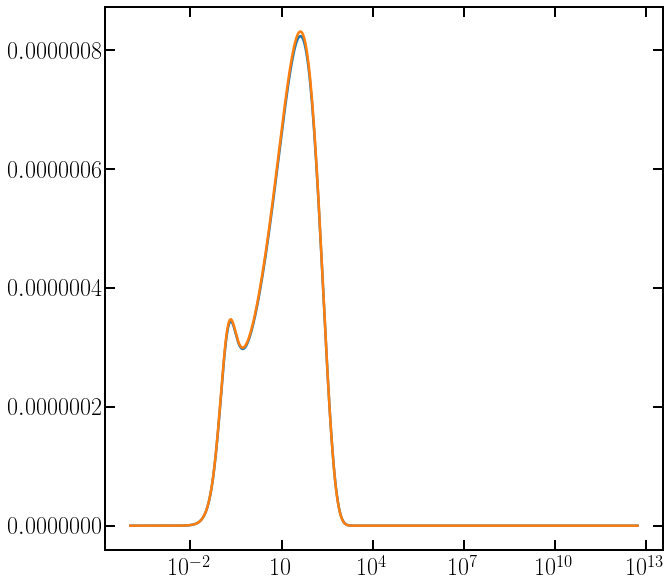

In [77]:
i = 3000
print(idl_redshift[i])

plt.figure()
ax = plt.gca()
ax.set_xscale('log')

photeng = idl_energy

plt.plot(photeng, b_4e12[3].grid_vals[i]*b_4e12[3].eng)
plt.plot(photeng, idl_lowengphot[i]*idl_bin_width*idl_energy)


## $f(z)$ Plots - Absolute Comparison

In [84]:
def get_absComparison(txt):
    injE = photeng[photeng < mDM/2][-1]


    f_H_ion_vec_math   = [f_H_ion(rs, injE) for rs in rs_vec[1:]]
    f_He_ion_vec_math  = [f_He_ion(rs, injE) for rs in rs_vec[1:]]
    f_exc_vec_math     = [f_H_exc(rs, injE) for rs in rs_vec[1:]]
    f_heat_vec_math    = [f_heating(rs, injE) for rs in rs_vec[1:]]
    f_cont_vec_math    = [f_cont(rs, injE) for rs in rs_vec[1:]]

    f_vec_math = np.vstack([
        f_H_ion_vec_math, f_He_ion_vec_math, 
        f_exc_vec_math, f_heat_vec_math, 
        f_cont_vec_math
    ])


    plt.figure(figsize=(10,50))
    plt.subplots_adjust(hspace=.4)

    ind2=100

    for i in range(5):
        plt.subplot(5,1,i+1)
        ax = plt.gca()
        ax.set_xscale('log')
        ax.set_yscale('log')
        plt.xlabel('Redshift')
        plt.ylabel('f(z)')
        if i == 0:
            plt.title('Hydrogen Ionization'+txt)
        elif i == 1:
            plt.title('Helium Ionization'+txt)
        elif i == 2:
            plt.title('Excitation'+txt)
        elif i == 3:
            plt.title('Heating'+txt)
        elif i == 4:
            plt.title('Continuum'+txt)
    #     plt.xlim([1660, 2900])
    #     plt.axis([1000, 3000, 1e-7, .3])
#         plt.axvline(1.118933e3)
#         plt.axvline(1.017e3)
#         plt.axvline(973)
#         plt.axvline(1653.35375194)
        plt.plot(rs_vec[ind2:tmpInd], b_4e12[6][0][ind2:tmpInd,i], label='DarkHistory Low fine')
#         plt.plot(rs_vec[ind2:tmpInd], b_4e120[6][0][ind2:tmpInd,i], label='DarkHistory Low coarse')
    #     plt.plot(rs_vec[1:], b_4e12[6][1][:,i], label='DarkHistory High')
    #     plt.plot(rs_vec[1:], f_vec_math[i], label='Mathematica')
    #     plt.plot(rs_vec, f_idl[i], label='IDL')
        plt.plot(rs_vec[ind2:tmpInd], f_idl_low[i,ind2:tmpInd], label='IDL Low')
    #     plt.plot(rs_vec, f_idl_high[i], label='IDL High')

        plt.legend()
#     plt.savefig('/home/gridgway/Desktop/DH_Data/pre1700_standard_xe_xHe/fzs_'+txt+'.png')


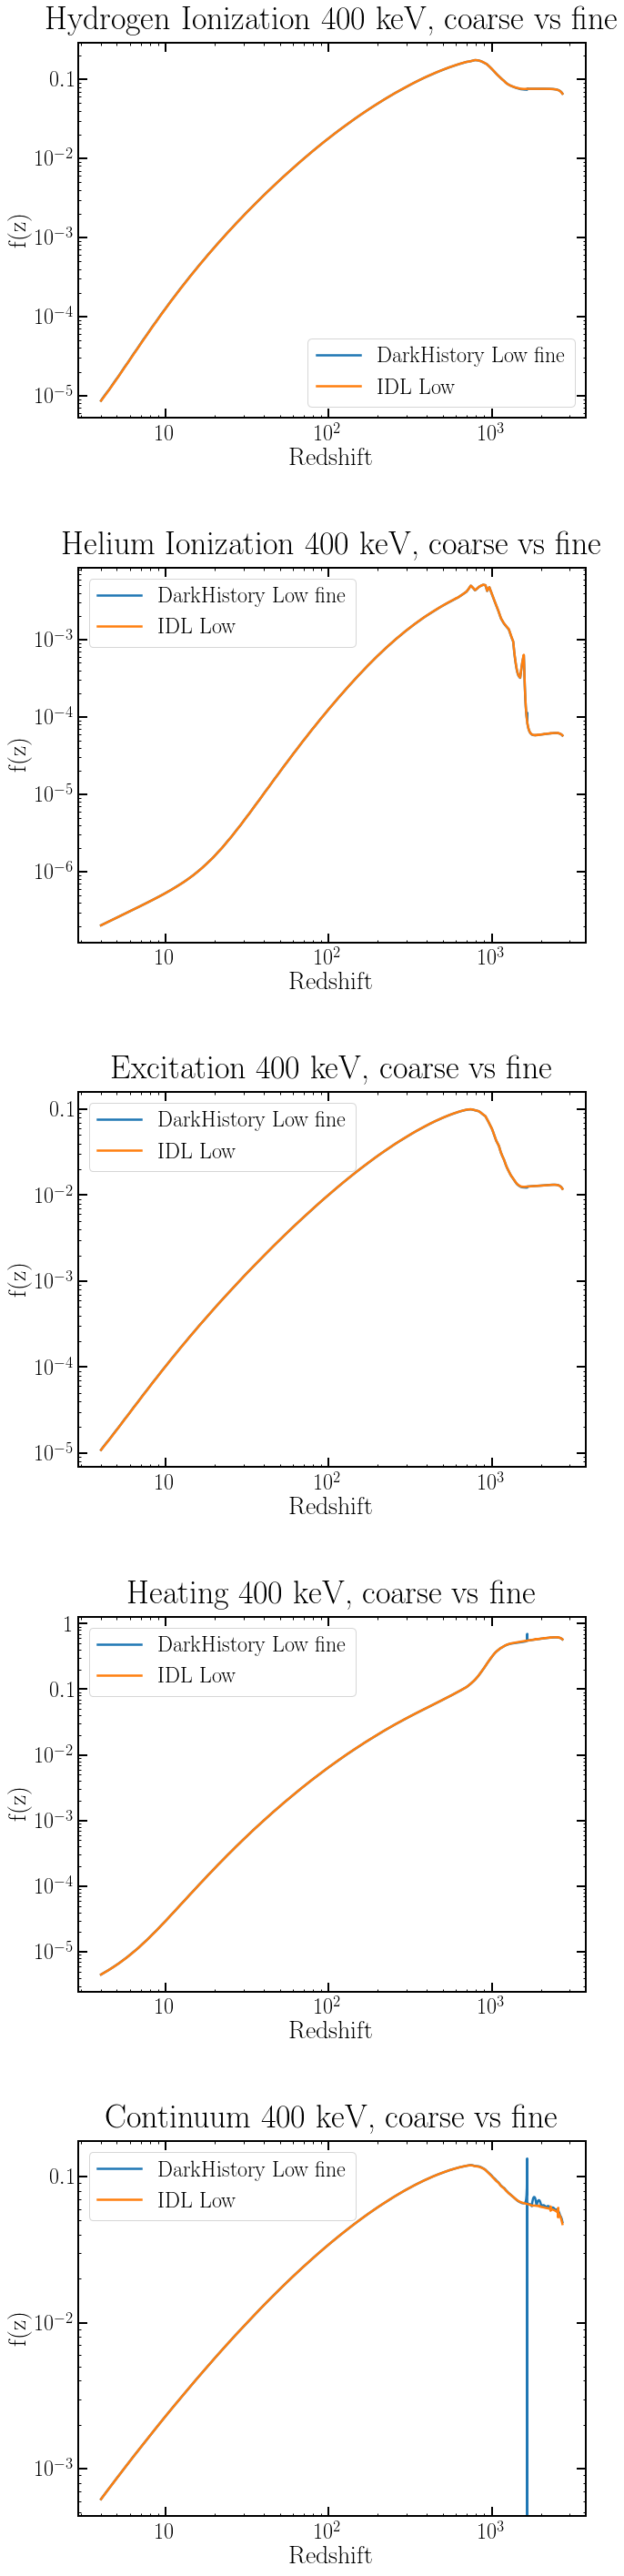

In [85]:
get_absComparison(" 400 keV, coarse vs fine")

/home/gridgway/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/home/gridgway/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


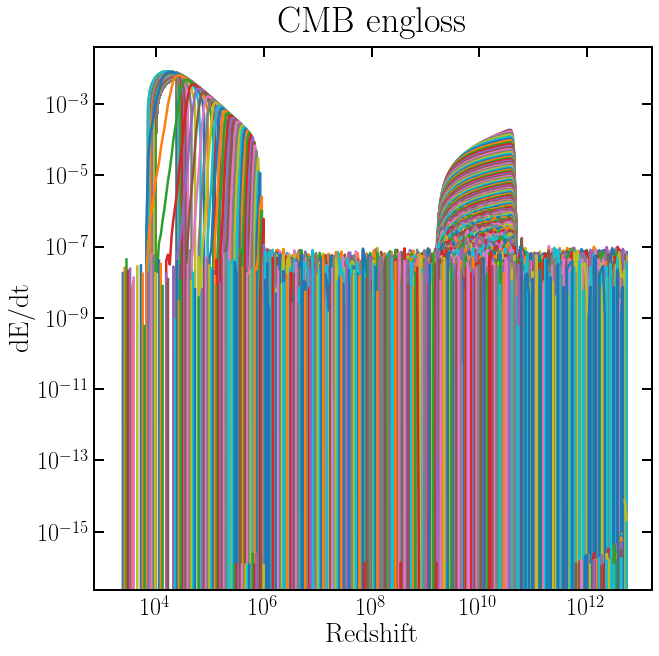

In [258]:
rsTmp = 1040.18717161
injInd = [len(photeng[photeng < mDM/2])-1, 300]
# ind2=300
ind2=0

plt.figure()
ax = plt.gca()
ax.loglog()

plt.xlabel('Redshift')
plt.ylabel('dE/dt')
plt.title('CMB engloss')

# plt.plot(photeng[ind2:], CMB_engloss_interp0.get_val(rs=rsTmp, xe=.5)[ind2:], label='interpolated')
# plt.plot(photeng[ind2:], CMB_engloss_interp.get_val(rs=rsTmp, xe=.5)[ind2:], label='interpolated')

# plt.plot(photeng[ind2:], highengphot_tf_interp0.get_tf(rs=rsTmp, xe=.5)._grid_vals[injInd][ind2:], label='interpolated')
# plt.plot(photeng[ind2:], highengphot_tf_interp.get_tf(rs=rsTmp, xe=.5)._grid_vals[injInd][ind2:], label='interpolated')

# plt.plot(photeng, 
#          (CMB_engloss_interp.get_val(rs=rsTmp, xe=.5)-CMB_engloss_interp0.get_val(rs=rsTmp, xe=.5))*
#          1/CMB_engloss_interp.get_val(rs=rsTmp, xe=.5)
#          , label='interpolated')

plt.plot(photeng, 
         (highengphot_tf_interp.get_tf(rs=rsTmp, xe=.5)._grid_vals-highengphot_tf_interp0.get_tf(rs=rsTmp, xe=.5)._grid_vals)*
         1/highengphot_tf_interp.get_tf(rs=rsTmp, xe=.5)._grid_vals
         , label='interpolated')

In [294]:
highengphot_tf_interp.rs

array([array([ 911.19277434,  973.5558714 , 1040.18717161, 1111.37879578,
       1187.44285781, 1268.71283303, 1355.54502022, 1448.32010365,
       1547.44482208, 1653.35375194]),
       array([1653.35375194, 1766.51121258, 1887.41330191, 2016.59007136,
       2154.60784969, 2302.07172587, 2459.62820186, 2627.96802697,
       2807.8292262 , 3000.00033585])], dtype=object)

In [287]:
highengphot_tf_interp0.rs

array([   4.        ,    4.56626611,    5.21269655,    5.9506399 ,
          6.79305133,    7.75472002,    8.85252881,   10.10575058,
         11.5363866 ,   13.16955279,   15.03392065,   17.1622206 ,
         19.59181658,   22.36536203,   25.53154867,   29.14596137,
         33.27205392,   37.98226307,   43.35928017,   49.49750292,
         56.50469254,   64.50386567,   73.63545397,   84.05976951,
         95.95981921,  109.54451763,  125.05235464,  142.75558229,
        162.9649944 ,  186.03538282,  212.37176602,  242.43649955,
        276.75739302,  315.93697621,  360.66307695,  411.72089648,
        470.00679424,  536.54402417,  612.50069871,  699.21029593,
        798.19506977,  911.19277434, 1040.18717161, 1187.44285781,
       1355.54502022, 1547.44482208, 1766.51121258, 2016.59007136,
       2302.07172587, 2627.96802697, 3000.00033585])

In [300]:
highengphot_tf_interp0.xe

array([4.53978687e-05, 2.74578156e-04, 1.65880108e-03, 9.95180187e-03,
       5.73241759e-02, 2.68941421e-01, 6.89974481e-01, 9.30861580e-01,
       9.87871565e-01, 9.97974680e-01, 9.99664650e-01])

In [301]:
highengphot_tf_interp.xe_arr

array([array([4.53978687e-05, 2.74578156e-04, 1.65880108e-03, 9.95180187e-03,
       5.73241759e-02, 1.67981615e-01, 2.68941421e-01, 3.82252125e-01,
       5.00000000e-01, 5.98687660e-01, 6.89974481e-01, 8.02183889e-01,
       9.30861580e-01, 9.87871565e-01, 9.97974680e-01, 9.99664650e-01]),
       None], dtype=object)

In [323]:
lowengelec_tf_interp.get_tf(rs=rsTmp, xe=xeTmp)._grid_vals.shape

(500, 500)

/home/gridgway/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in true_divide
/home/gridgway/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide


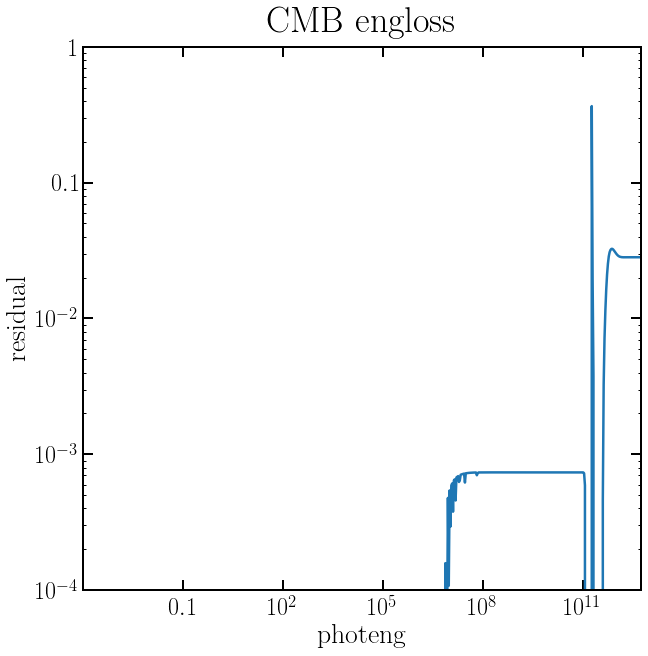

In [343]:
rsTmp =  973.5558714 #2807.8292262 #1448.32010365 #2459.62820186 #1040.18717161
xeTmp = 9.97974680e-01 #6.89974481e-01 #5.73241759e-02 #9.99664650e-01 #9.97974680e-01
injInd = 100#len(photeng[photeng < mDM/2])-1
# ind2=300
ind2=0

plt.figure()
ax = plt.gca()
ax.loglog()

plt.xlabel('photeng')

plt.title('CMB engloss')


# plt.ylabel('dE/dt')
# plt.plot(photeng[ind2:], CMB_engloss_interp0.get_val(rs=rsTmp, xe=.5)[ind2:], label='interpolated')
# plt.plot(photeng[ind2:], CMB_engloss_interp.get_val(rs=rsTmp, xe=.5)[ind2:], label='interpolated')

# plt.ylabel('dE/dt')
# plt.plot(photeng[ind2:], highengphot_tf_interp0.get_tf(rs=rsTmp, xe=.5)._grid_vals[injInd][ind2:], label='interpolated')
# plt.plot(photeng[ind2:], highengphot_tf_interp.get_tf(rs=rsTmp, xe=.5)._grid_vals[injInd][ind2:], label='interpolated')

# plt.axis([1e4, 8e5, .0001/1e2, 1])
# plt.ylabel('dE/dt')
# plt.plot(eleceng, lowengelec_tf_interp0.get_tf(rs=rsTmp, xe=xeTmp)._grid_vals[:, injInd], label='interpolated')
# plt.plot(eleceng, lowengelec_tf_interp.get_tf(rs=rsTmp, xe=xeTmp)._grid_vals[:, injInd], label='interpolated')



# plt.ylabel('residual')
# plt.axis([photeng[ind2], 4e5, .0001/1e2, 1])
# plt.plot(photeng, 
#          (CMB_engloss_interp.get_val(rs=rsTmp, xe=xeTmp)-CMB_engloss_interp0.get_val(rs=rsTmp, xe=xeTmp))*
#          1/CMB_engloss_interp.get_val(rs=rsTmp, xe=xeTmp)
#          , label='interpolated')

# plt.ylabel('residual')
# plt.axis([photeng[ind2], 4e5, .0001/1e2, 1])
# plt.plot(photeng, 
#          (highengphot_tf_interp.get_tf(rs=rsTmp, xe=.5)._grid_vals-highengphot_tf_interp0.get_tf(rs=rsTmp, xe=.5)._grid_vals)*
#          1/highengphot_tf_interp.get_tf(rs=rsTmp, xe=.5)._grid_vals
#          , label='interpolated')

plt.ylabel('residual')
plt.axis([photeng[ind2], photeng[-1], .0001, 1])
plt.plot(eleceng, 
         ((lowengelec_tf_interp.get_tf(rs=rsTmp, xe=xeTmp)._grid_vals-lowengelec_tf_interp0.get_tf(rs=rsTmp, xe=xeTmp)._grid_vals)*
         1/lowengelec_tf_interp.get_tf(rs=rsTmp, xe=xeTmp)._grid_vals)[:,injInd]
         , label='interpolated')

In [311]:
b_4e12[2]

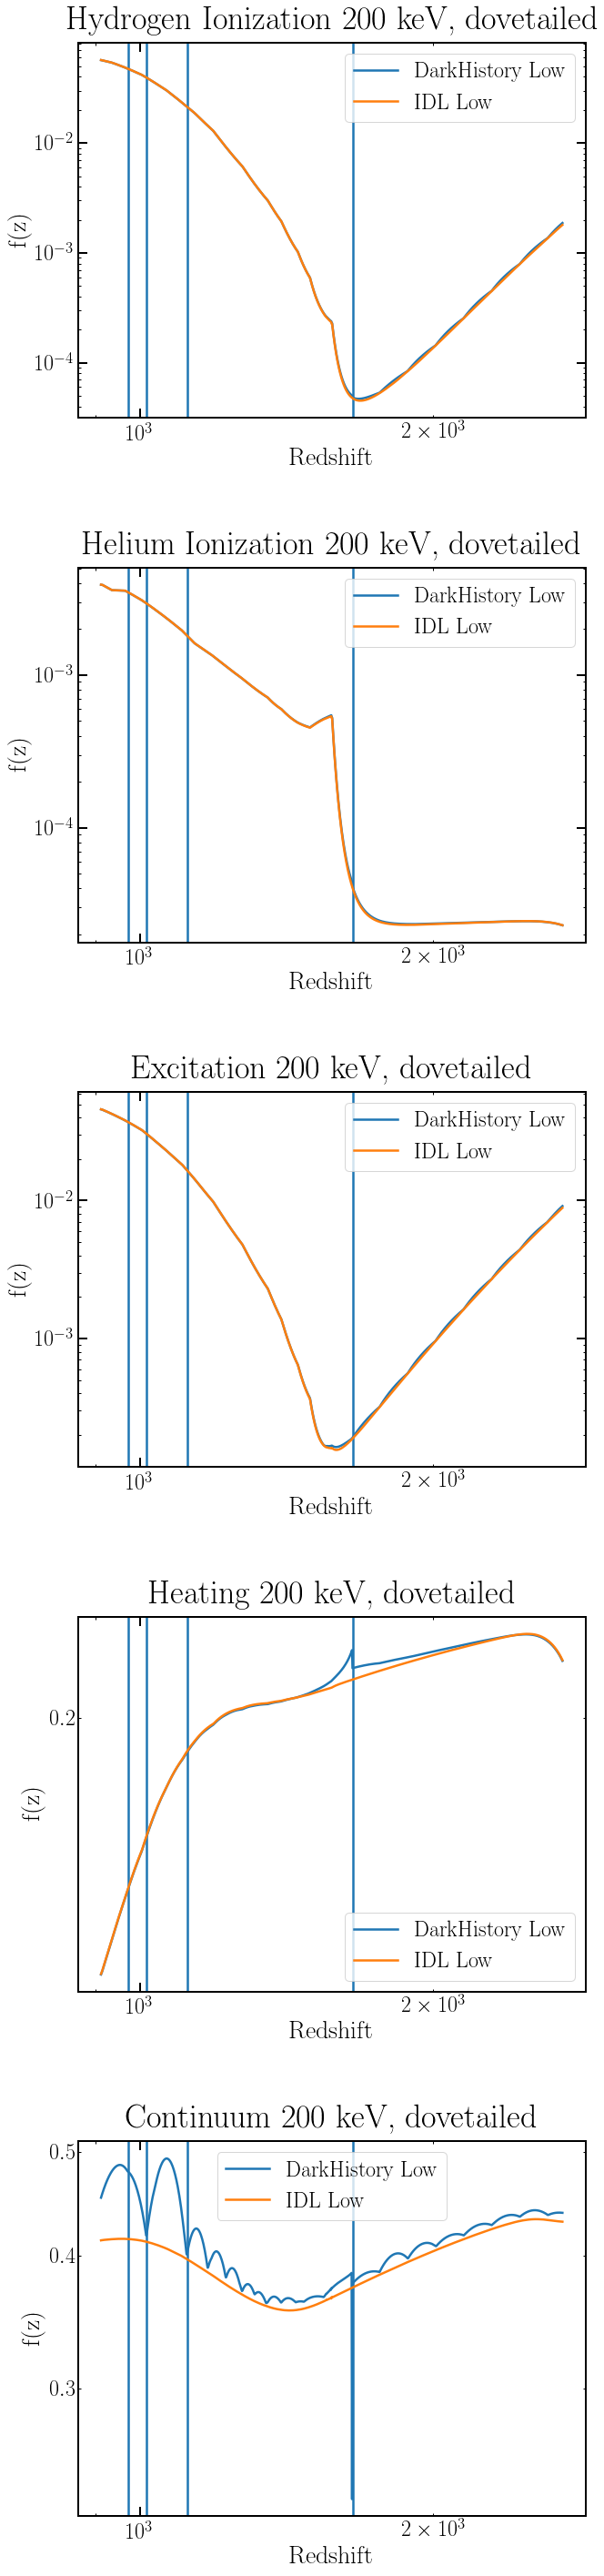

In [272]:
get_absComparison(' 200 keV, dovetailed')

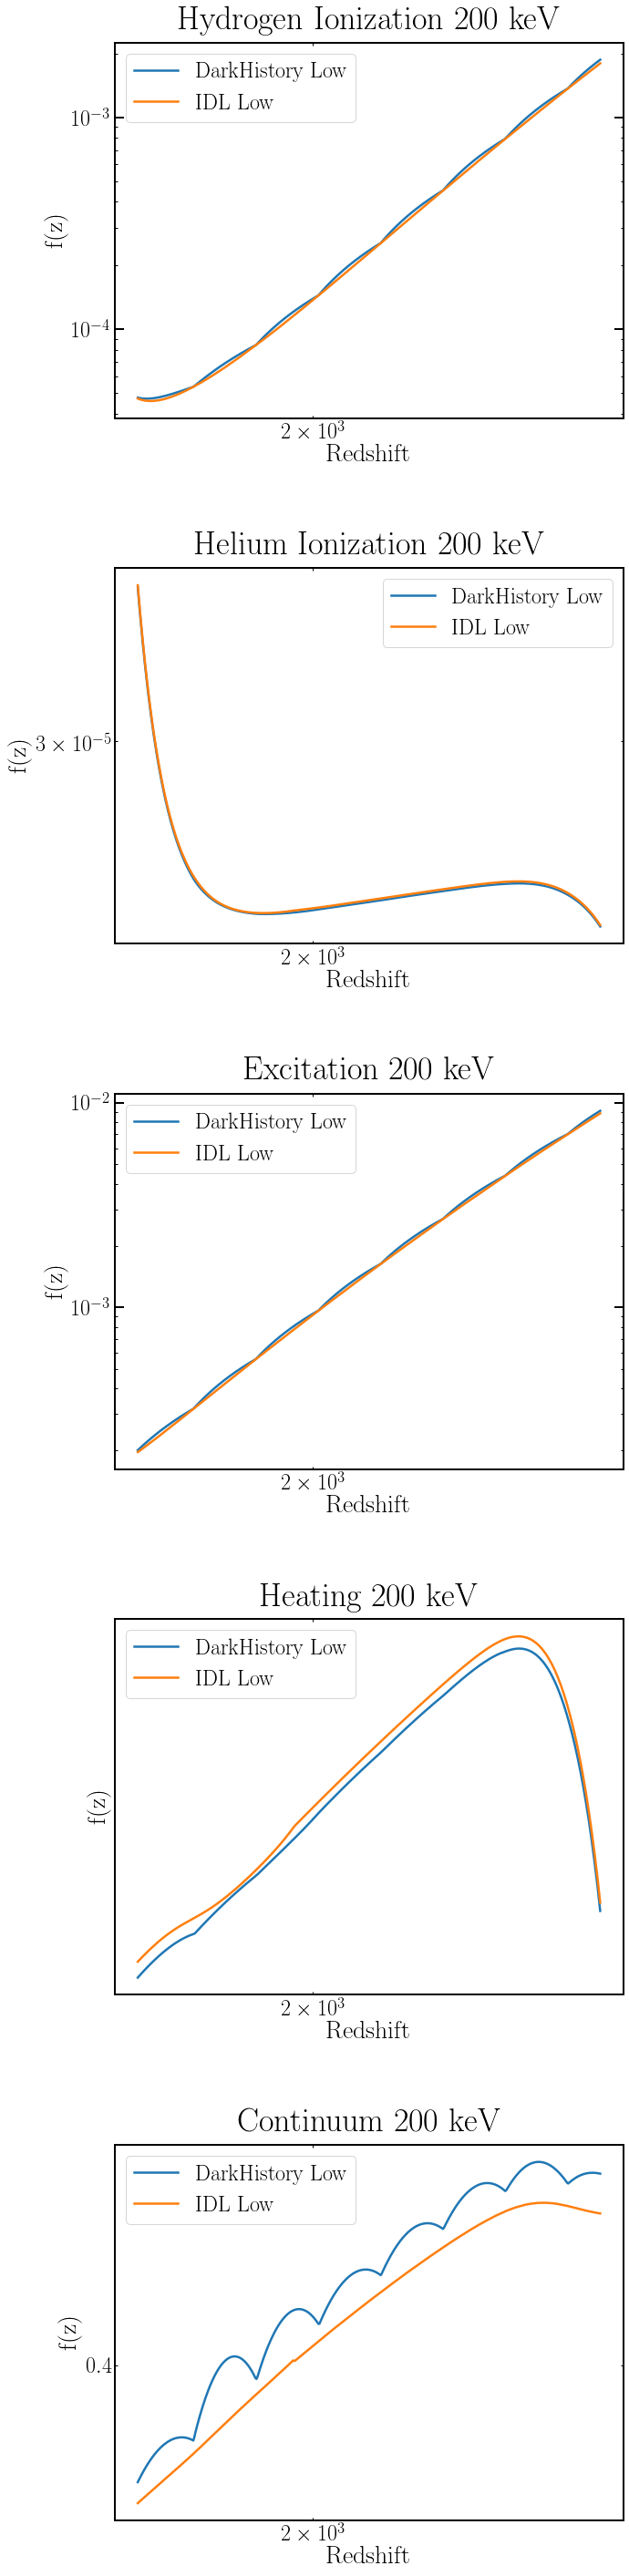

In [362]:
get_absComparison(' 200 keV')

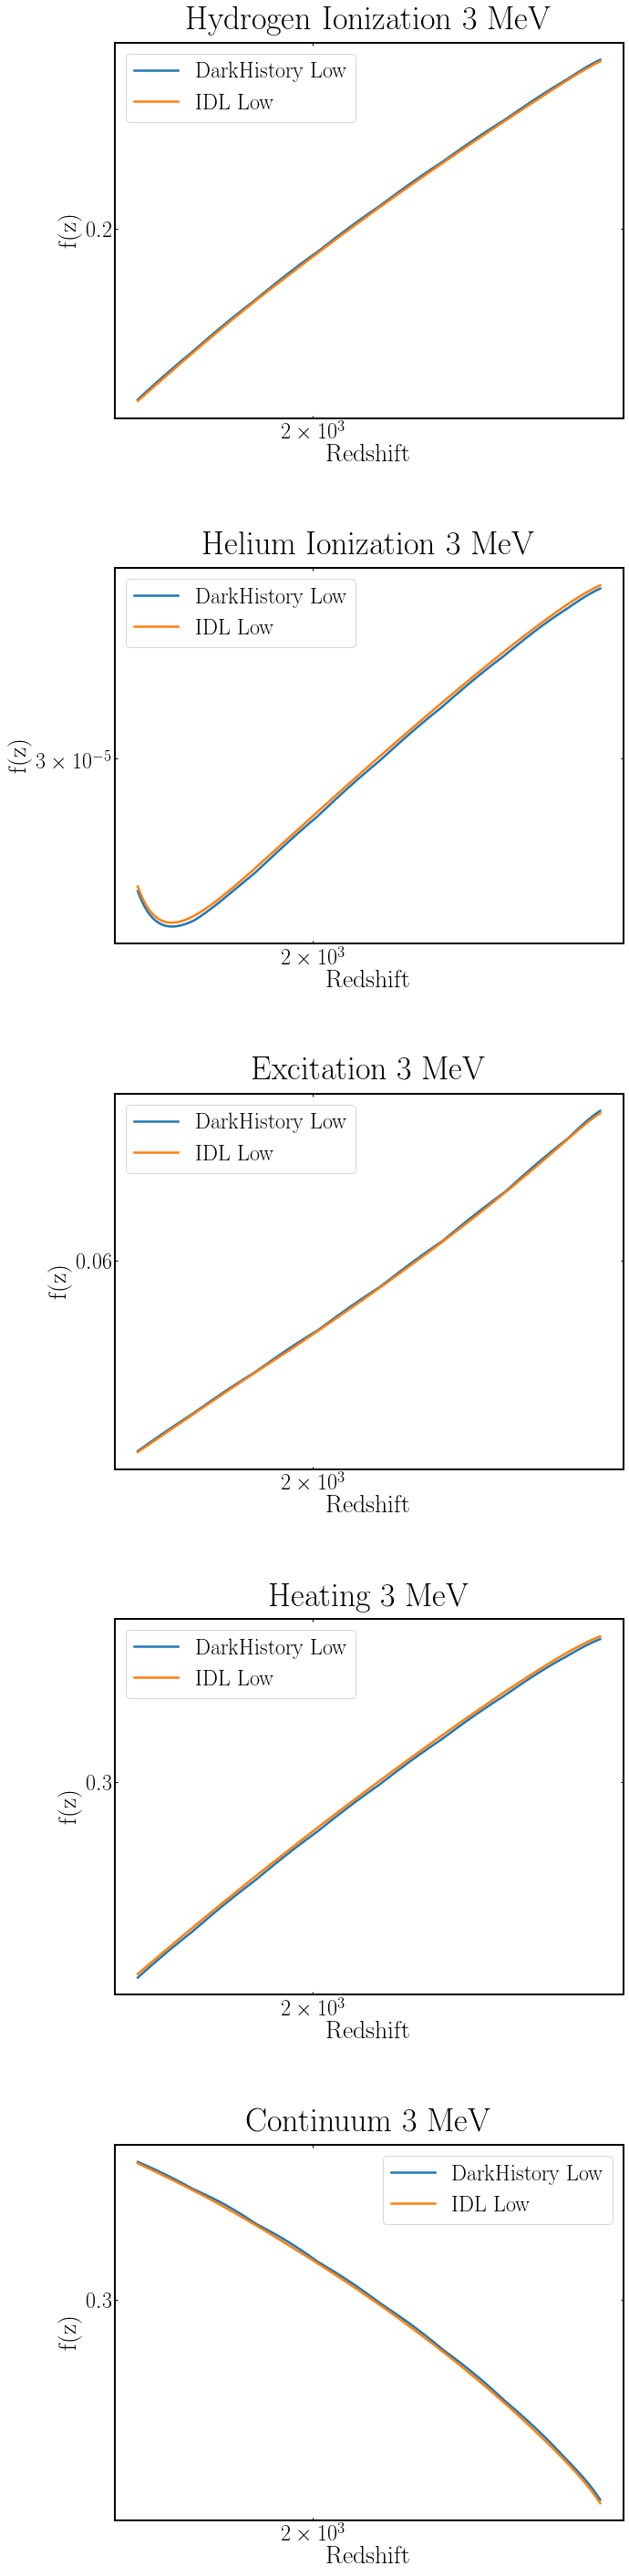

In [268]:
get_absComparison(' 3 MeV')

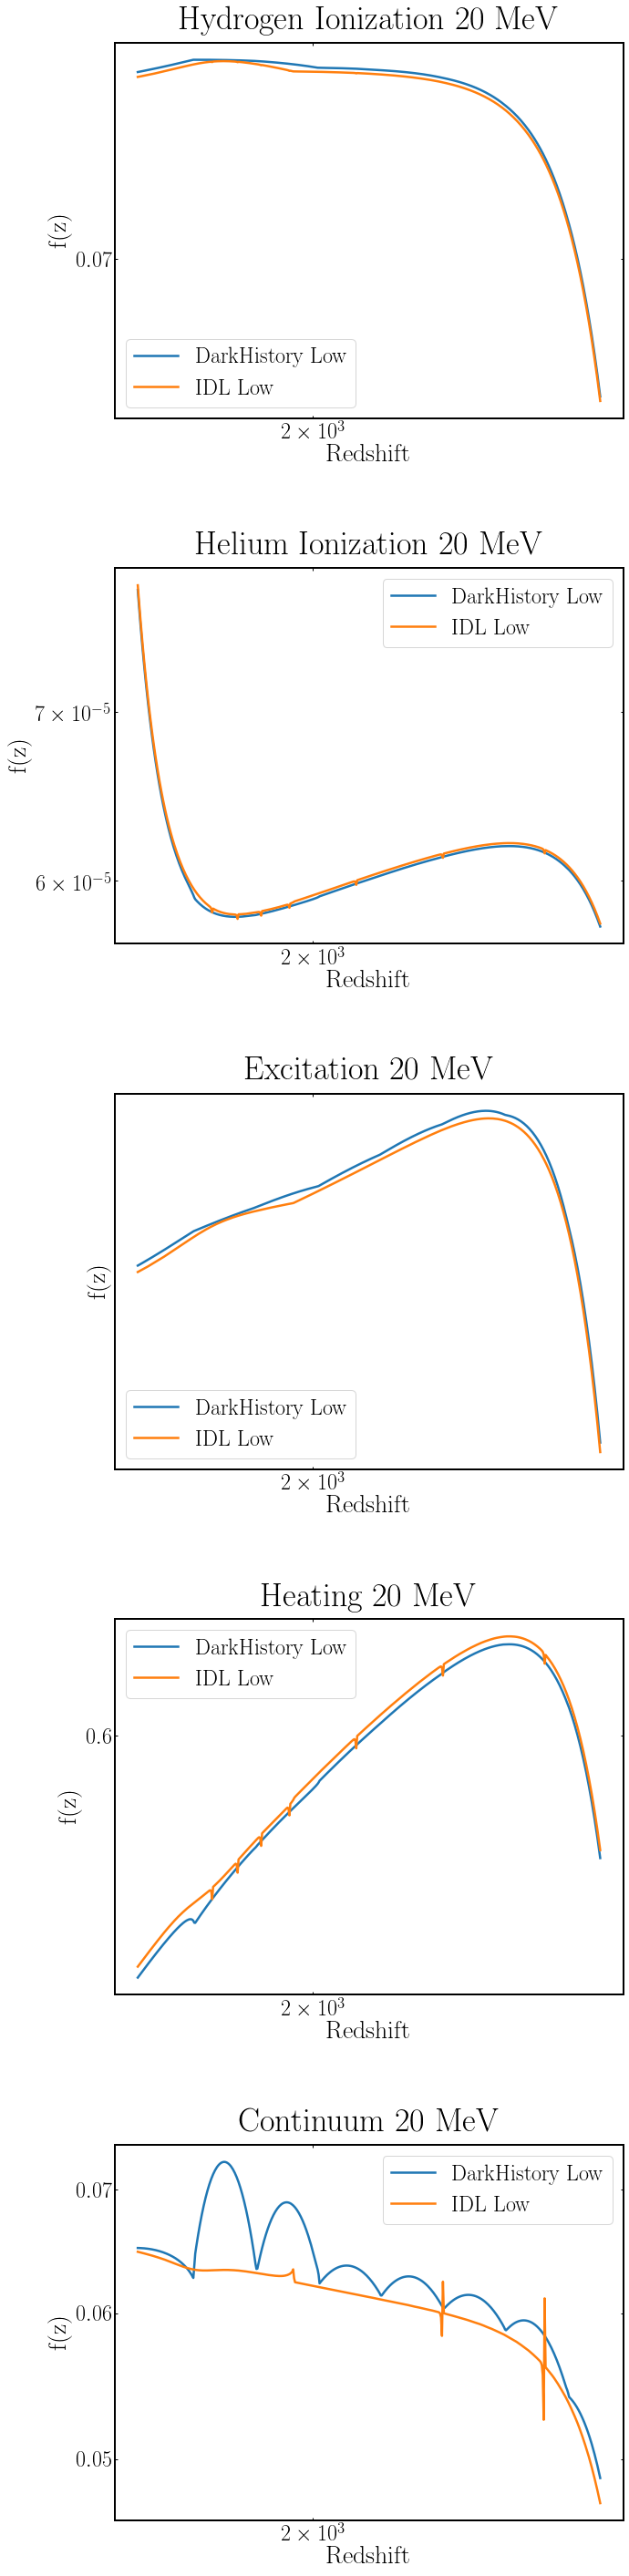

In [336]:
get_absComparison(' 20 MeV')

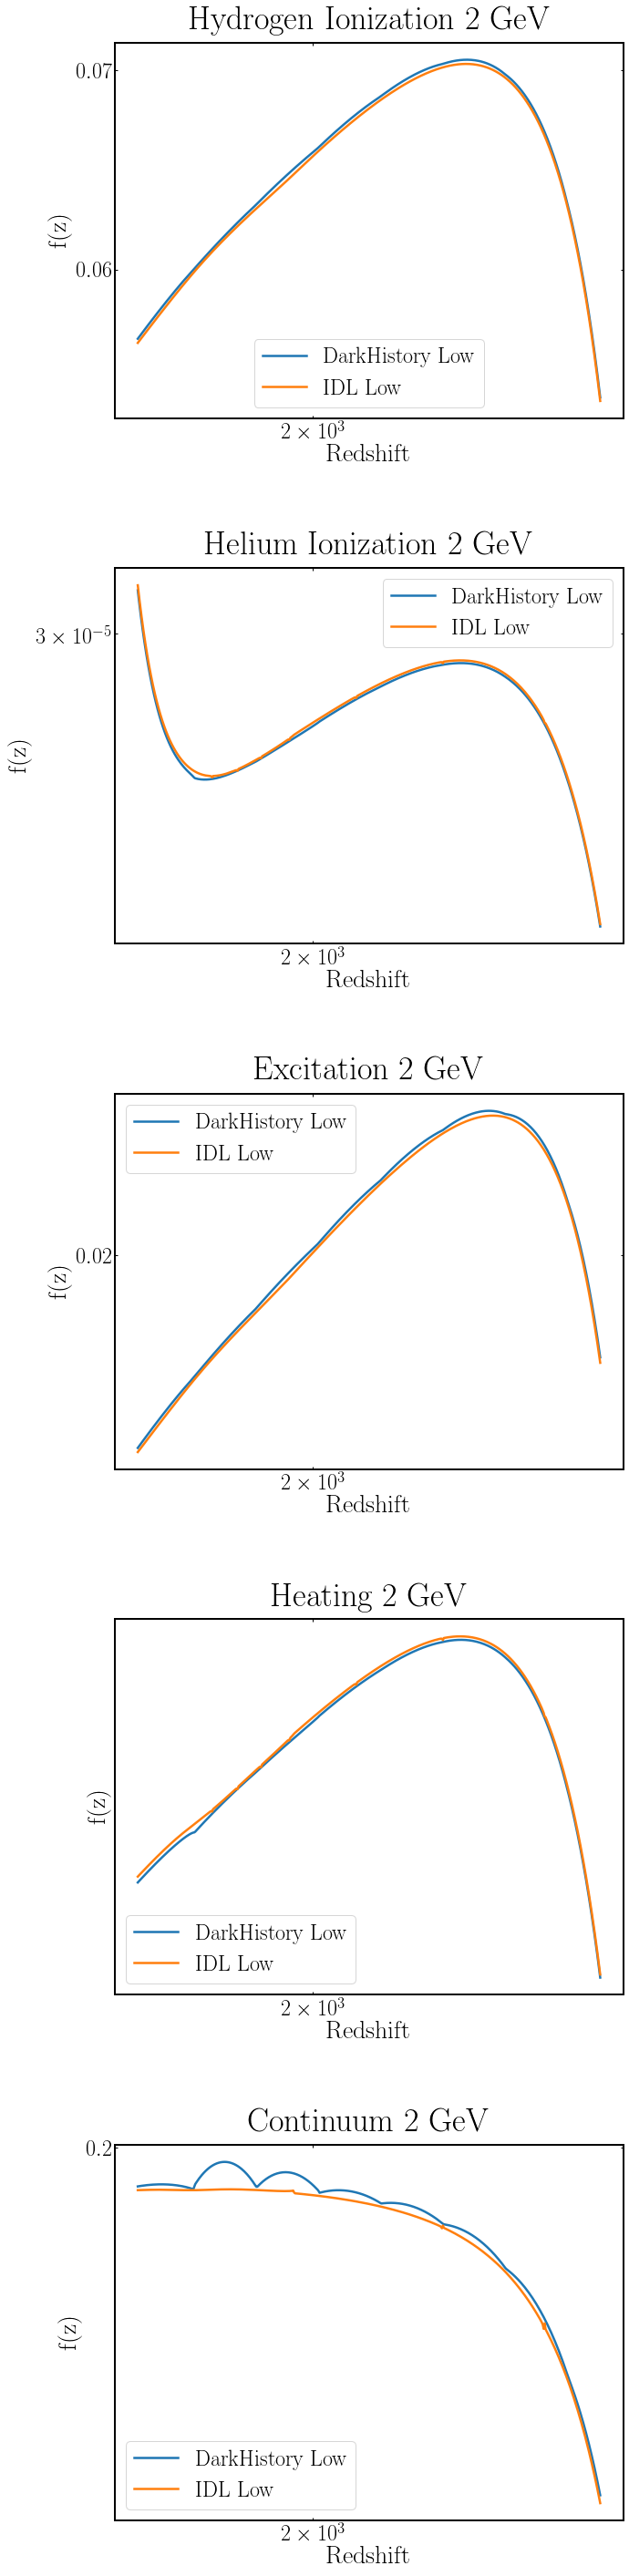

In [296]:
get_absComparison(' 2 GeV')

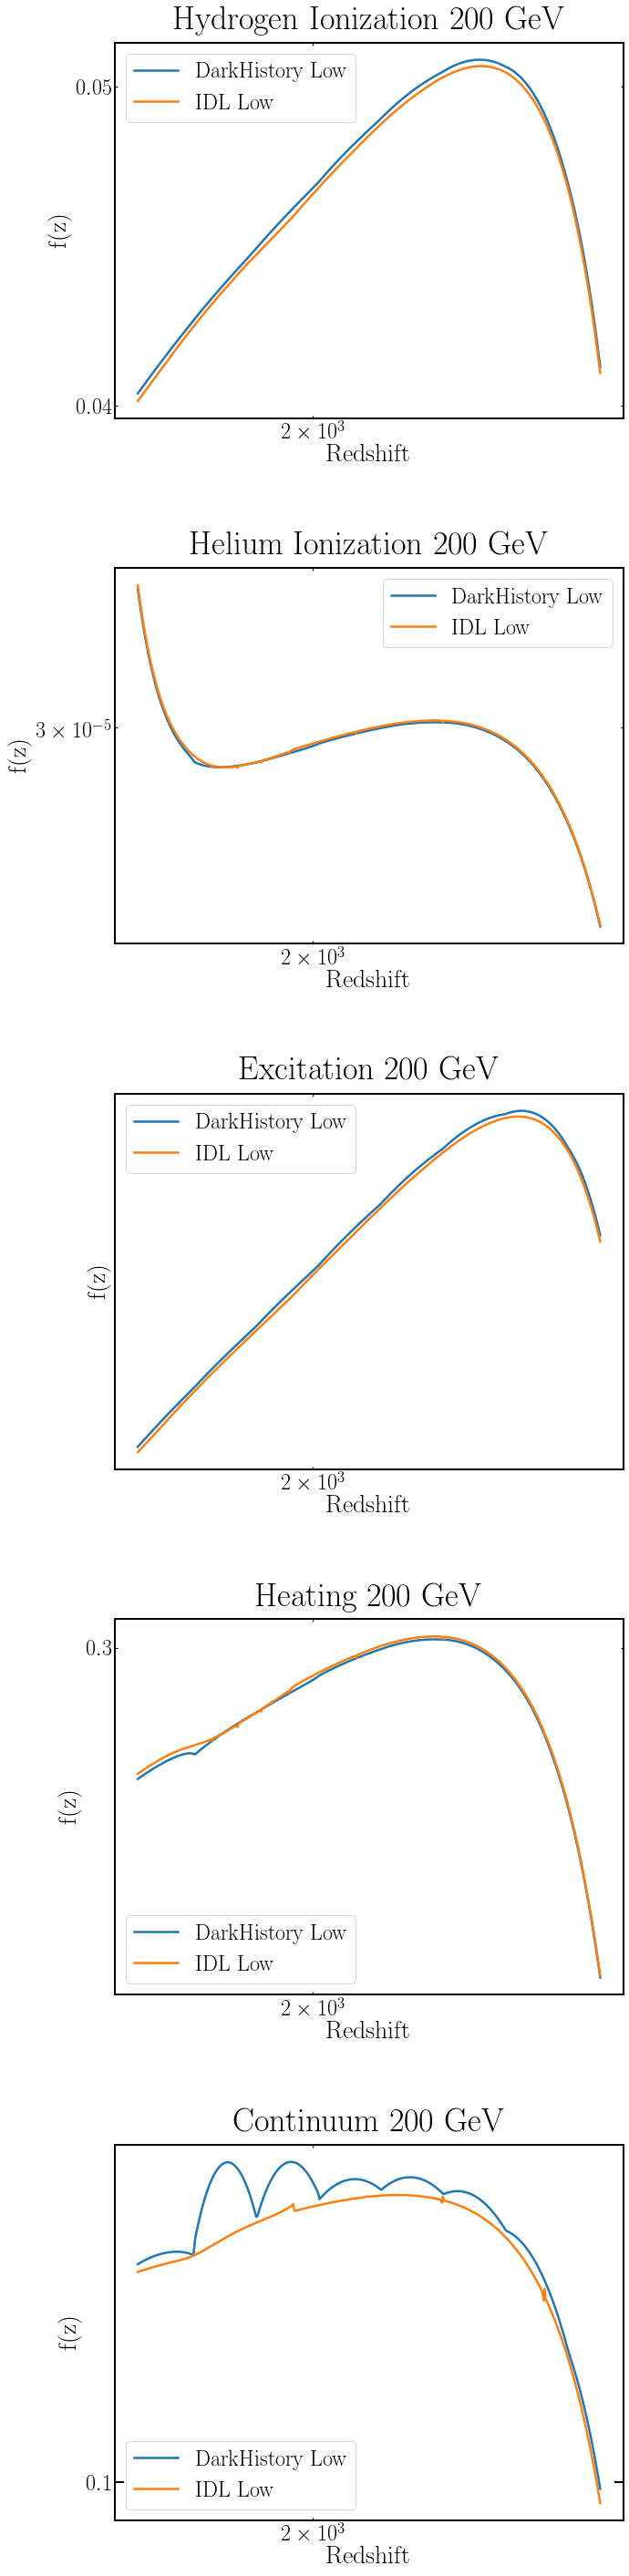

In [309]:
get_absComparison(' 200 GeV')

## $f(z)$ Plots - Relative Comparison

In [398]:
b_4e12[6][1][1:tmpInd,0]/b_4e12[6][0][1:tmpInd,0]

array([92.67352577,  0.11660858,  0.09419684, ...,  1.36215884,
        1.36222804,  1.36229824])

In [98]:
highengdep_interp.rs_nodes

array([1653.35375194])

In [102]:
dlnz = 1e-3
nzsteps = 51
initredshift = 3000
finredshift = 4
lnzstep = (np.log(initredshift) - np.log(finredshift))/(nzsteps-1)
redshiftgrid = np.exp(np.log(4) + lnzstep*np.arange(nzsteps))

In [106]:
redshiftgrid[:45+1]

array([   4.        ,    4.5662661 ,    5.21269653,    5.95063986,
          6.79305127,    7.75471993,    8.85252869,   10.10575042,
         11.53638639,   13.16955252,   15.03392032,   17.16222018,
         19.59181605,   22.36536138,   25.53154787,   29.14596039,
         33.27205273,   37.98226162,   43.35927842,   49.49750081,
         56.50469001,   64.50386264,   73.63545034,   84.05976518,
         95.95981406,  109.5445115 ,  125.05234736,  142.75557366,
        162.96498418,  186.03537074,  212.37175176,  242.43648273,
        276.75737319,  315.93695286,  360.66304949,  411.72086421,
        470.00675635,  536.54397972,  612.50064659,  699.21023488,
        798.19499828,  911.19269069, 1040.18707379, 1187.44274349,
       1355.54488667, 1547.44466616])

In [99]:
def get_relComparison(txt):
    injE = photeng[photeng < mDM/2][-1]


    f_H_ion_vec_math   = [f_H_ion(rs, injE) for rs in rs_vec[1:]]
    f_He_ion_vec_math  = [f_He_ion(rs, injE) for rs in rs_vec[1:]]
    f_exc_vec_math     = [f_H_exc(rs, injE) for rs in rs_vec[1:]]
    f_heat_vec_math    = [f_heating(rs, injE) for rs in rs_vec[1:]]
    f_cont_vec_math    = [f_cont(rs, injE) for rs in rs_vec[1:]]

    f_vec_math = np.vstack([
        f_H_ion_vec_math, f_He_ion_vec_math, 
        f_exc_vec_math, f_heat_vec_math, 
        f_cont_vec_math
    ])


    plt.figure(figsize=(10,50))
    plt.subplots_adjust(hspace=.4)

    for i in range(5):
        plt.subplot(5,1,i+1)
        ax = plt.gca()
#         ax.set_xscale('log')
    #     ax.set_yscale('log')
        plt.xlabel('Redshift')
        plt.ylabel('f(z)$_{higheng}$ / f(z)$_{loweng}$')
        if i == 0:
            plt.title('Hydrogen Ionization'+txt)
        elif i == 1:
            plt.title('Helium Ionization'+txt)
        elif i == 2:
            plt.title('Excitation'+txt)
        elif i == 3:
            plt.title('Heating'+txt)
        elif i == 4:
            plt.title('Continuum'+txt)
        
#         plt.axvline(1547)

        plt.axis([10, 3000, -0.25, 0.5])
#         plt.plot(rs_vec[1:tmpInd],
#                  (b_4e12[6][0][1:tmpInd,i]+b_4e12[6][1][1:tmpInd,i])/(
#                      f_idl_low[i,1:tmpInd] + f_idl_high[i,1:tmpInd])-1,
#                  label='DH/IDL, Low+High Fine')
#         plt.plot(rs_vec[1:tmpInd],
#                  (b_4e120[6][0][1:tmpInd,i]+b_4e120[6][1][1:tmpInd,i])/(
#                      f_idl_low[i,1:tmpInd] + f_idl_high[i,1:tmpInd])-1,
#                  label='DH/IDL, Low+High Coarse')

        plt.axis([10, 3000, -.5, .5])
#         plt.plot(rs_vec[1:tmpInd],f_idl_high[i,1:tmpInd]/f_idl_low[i,1:tmpInd], label='IDL high / low')
#         plt.plot(rs_vec[1:tmpInd],b_4e120[6][0][1:tmpInd,i]/f_idl_low[i,1:tmpInd]-1, label='DH/IDL, Low Coarse')
        plt.plot(rs_vec[1:tmpInd],b_4e12[6][1][1:tmpInd,i]/f_idl_high[i,1:tmpInd]-1, label='DH/IDL, High')
        plt.plot(rs_vec[1:tmpInd],b_4e12[6][0][1:tmpInd,i]/f_idl_low[i,1:tmpInd]-1, label='DH/IDL, Low')
#         plt.plot(rs_vec[1:tmpInd],b_4e120[6][1][1:tmpInd,i]/f_idl_high[i,1:tmpInd]-1, label='DH/IDL, High Coarse')
        
        ax.axhline(1, color='gray', linestyle=':')
        ax.axhline(0.95-1, color='gray', linestyle=':')
        ax.axhline(1.05-1, color='gray', linestyle=':')

        ax.axhline(0.9-1, color='gray', linestyle='--')
        ax.axhline(1.1-1, color='gray', linestyle='--')


        plt.legend()
    plt.savefig('/home/gridgway/Desktop/DH_Data/pre1700_standard_xe_xHe/fz_residuals_'+txt+'.png')

In [110]:
tmp1 = highengphot_tf_interp.tfInterps[0].get_tf(rs=1653, xe=xe_idl_func(1653))._grid_vals
tmp2 = highengphot_tf_interp.tfInterps[1].get_tf(rs=1653, xe=xe_idl_func(1653))._grid_vals

In [122]:
((tmp1-tmp2)/(tmp2+1e-200))[300]

array([-1.14506778e-02, -1.14508518e-02, -1.14508712e-02, -1.14510091e-02,
       -1.14508536e-02, -1.14510063e-02, -1.14510393e-02, -1.14511155e-02,
       -1.14510790e-02, -1.14512024e-02, -1.14513027e-02, -1.14512515e-02,
       -1.14513251e-02, -1.14514521e-02, -1.14515142e-02, -1.14516338e-02,
       -1.14516578e-02, -1.14517787e-02, -1.14519383e-02, -1.14520440e-02,
       -1.14521246e-02, -1.14522606e-02, -1.14523221e-02, -1.14525514e-02,
       -1.14527183e-02, -1.14528729e-02, -1.14530464e-02, -1.14533048e-02,
       -1.14534941e-02, -1.14538161e-02, -1.14540194e-02, -1.14542914e-02,
       -1.14546356e-02, -1.14549454e-02, -1.14553461e-02, -1.14556603e-02,
       -1.14560528e-02, -1.14565780e-02, -1.14569442e-02, -1.14575272e-02,
       -1.14581289e-02, -1.14586819e-02, -1.14593760e-02, -1.14601129e-02,
       -1.14607837e-02, -1.14616304e-02, -1.14625121e-02, -1.14634438e-02,
       -1.14644916e-02, -1.14657525e-02, -1.14668512e-02, -1.14682758e-02,
       -1.14696066e-02, -

In [123]:
tmp1 = highengphot_tf_interp.tfInterps[0].get_tf(rs=1653, xe=xe_idl_func(1653))
tmp2 = highengphot_tf_interp.tfInterps[1].get_tf(rs=1653, xe=xe_idl_func(1653))

In [125]:
highengphot_tf_interp.xe_arr

array([array([4.53978687e-05, 2.74578156e-04, 1.65880108e-03, 9.95180187e-03,
       2.65969936e-02, 5.73241759e-02, 1.19202922e-01, 1.67981615e-01,
       2.14165017e-01, 2.68941421e-01, 3.82252125e-01, 5.00000000e-01,
       5.98687660e-01, 6.89974481e-01, 8.02183889e-01, 9.30861580e-01,
       9.87871565e-01, 9.97974680e-01, 9.99664650e-01]),
       None], dtype=object)

In [ ]:
tmp1

In [114]:
np.average((tmp1-tmp2+1e-200)/(tmp2+1e-200))

5.52124353277517e+191

/home/gridgway/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide


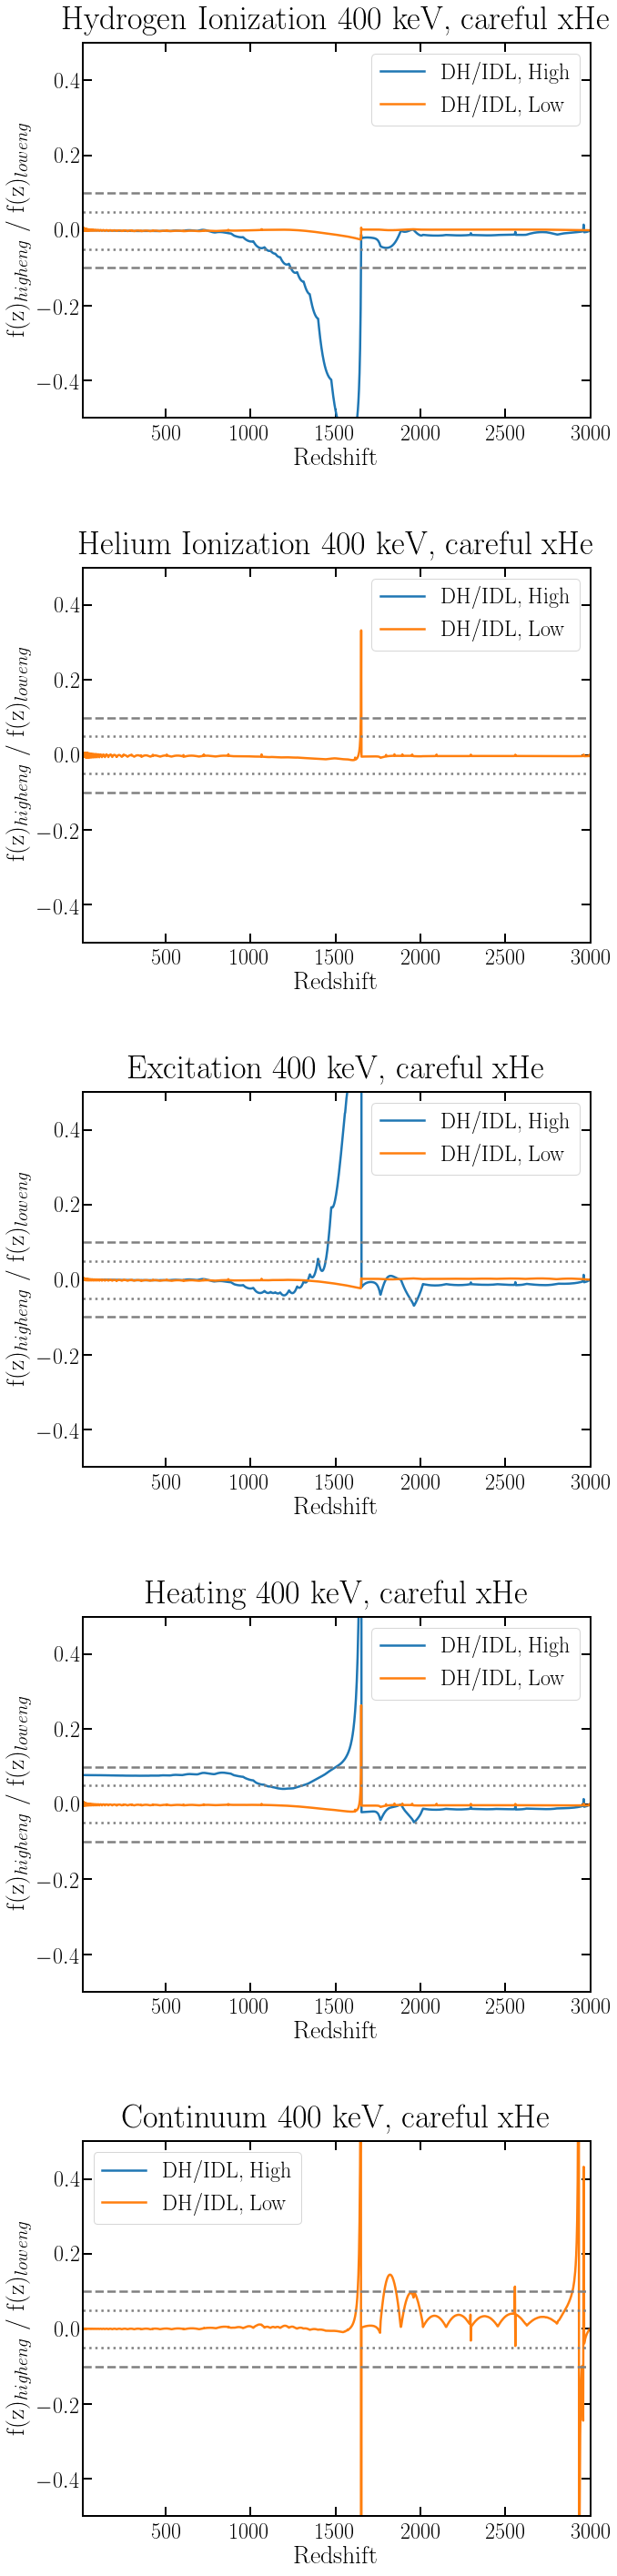

In [100]:
get_relComparison(' 400 keV, careful xHe')

/home/gridgway/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide


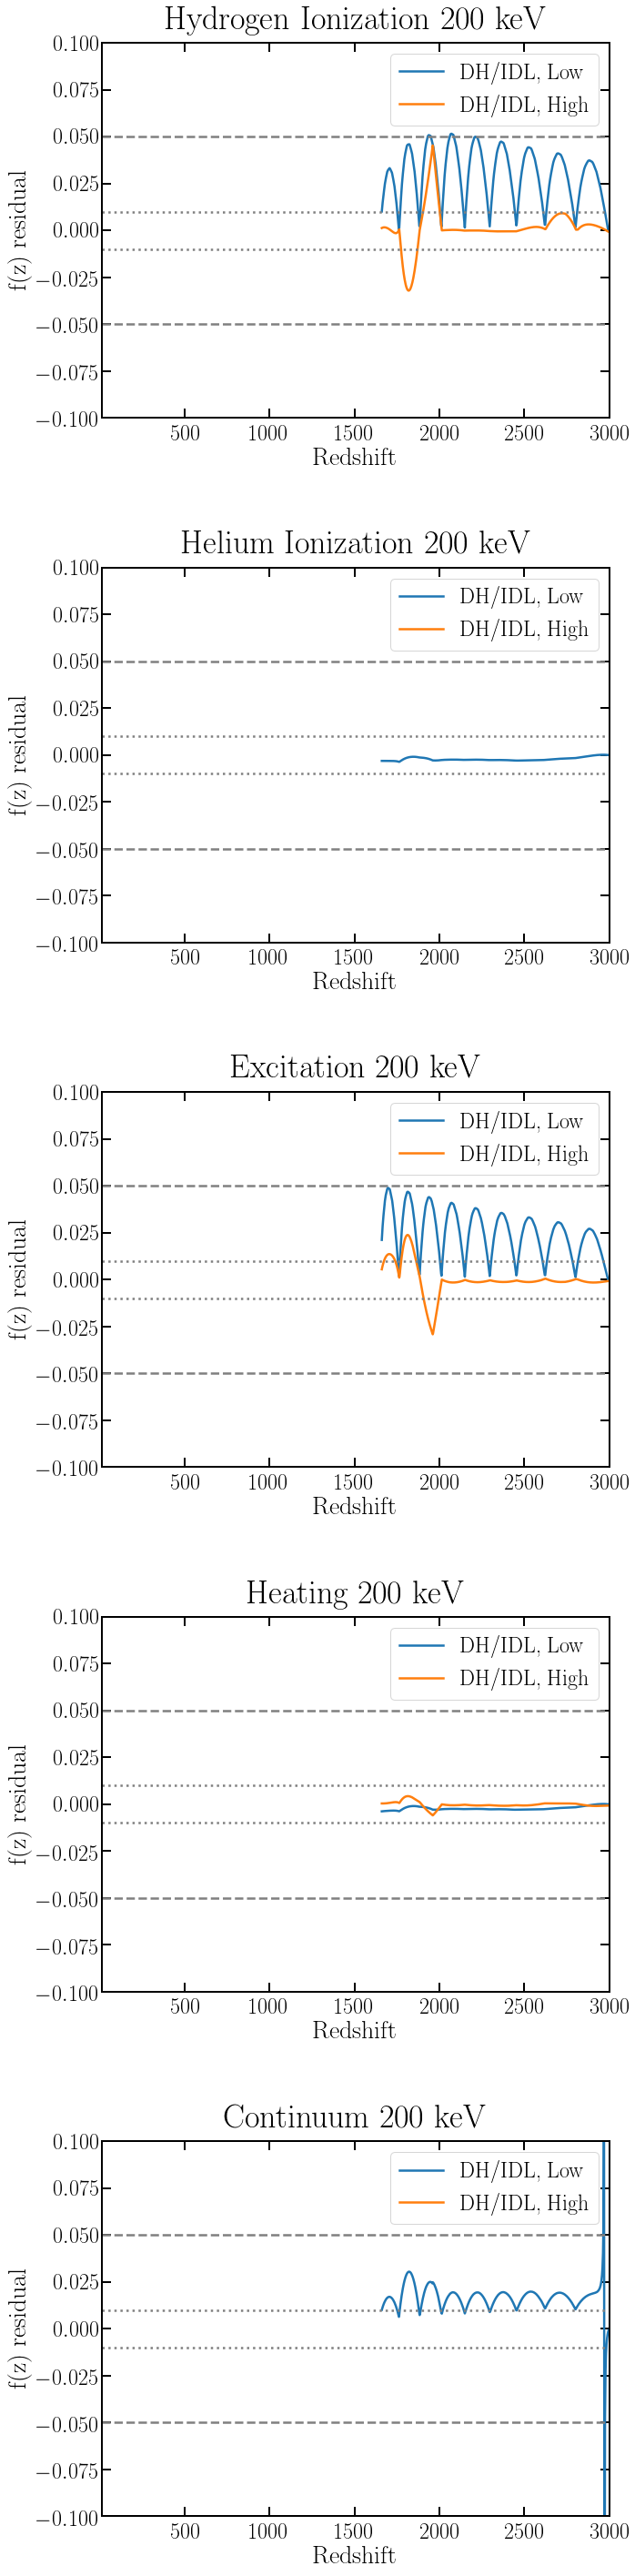

In [363]:
get_relComparison(' 200 keV')

/home/gridgway/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide


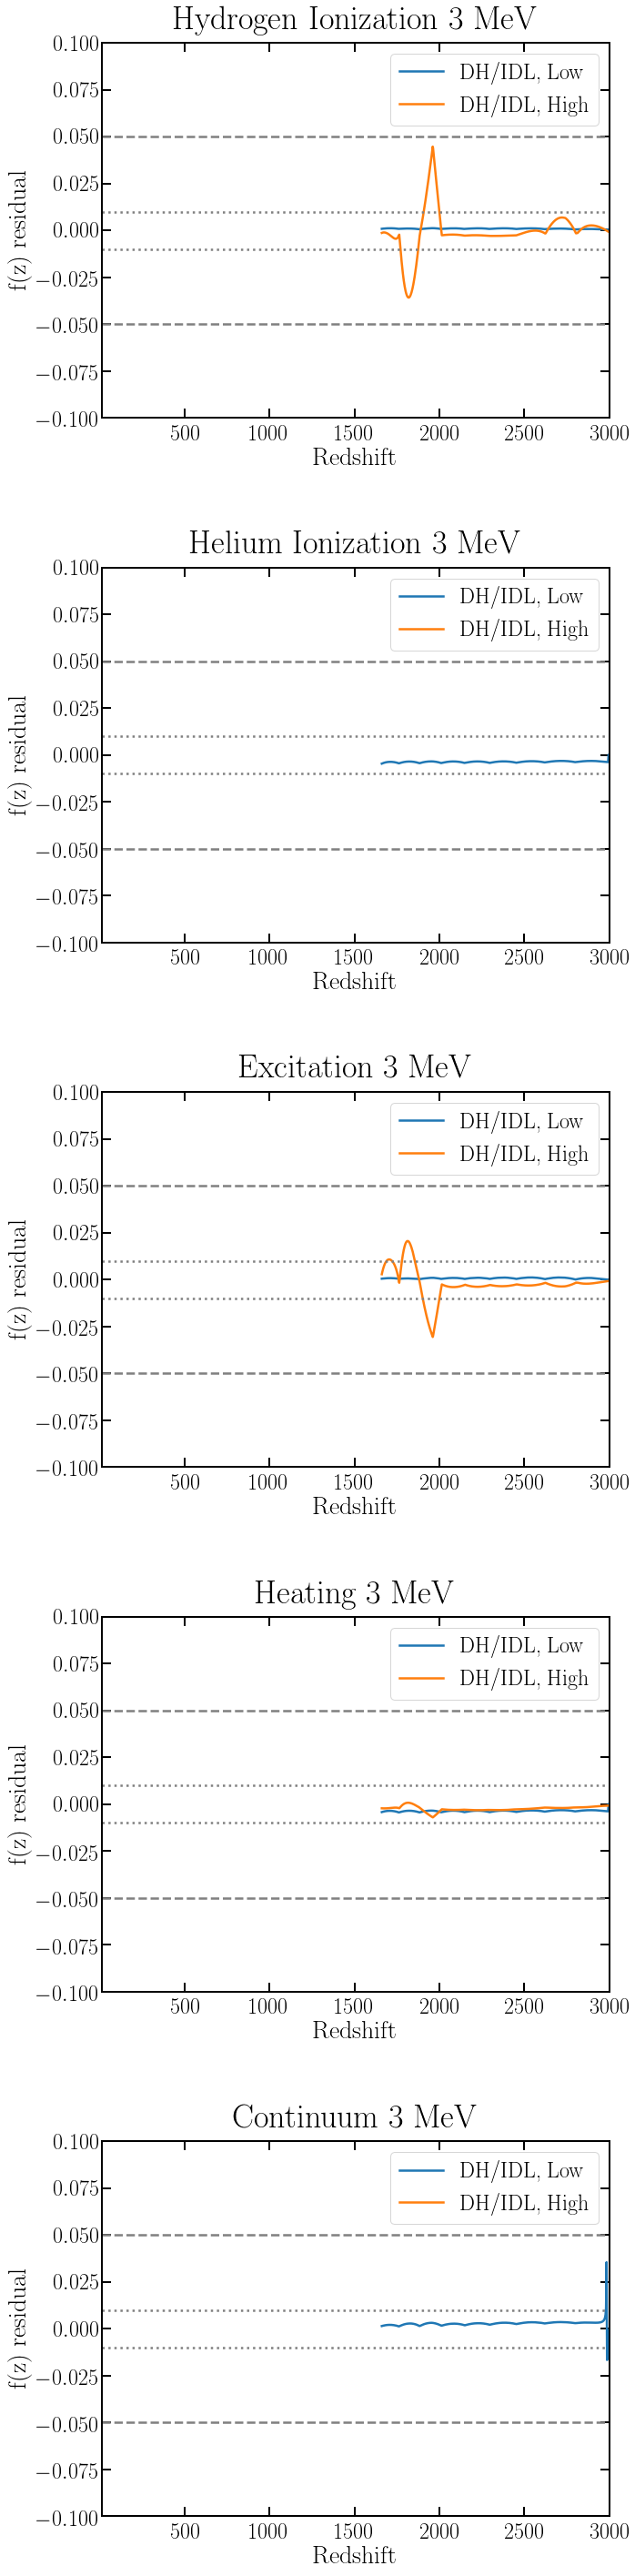

In [323]:
get_relComparison(' 3 MeV')

/home/gridgway/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide


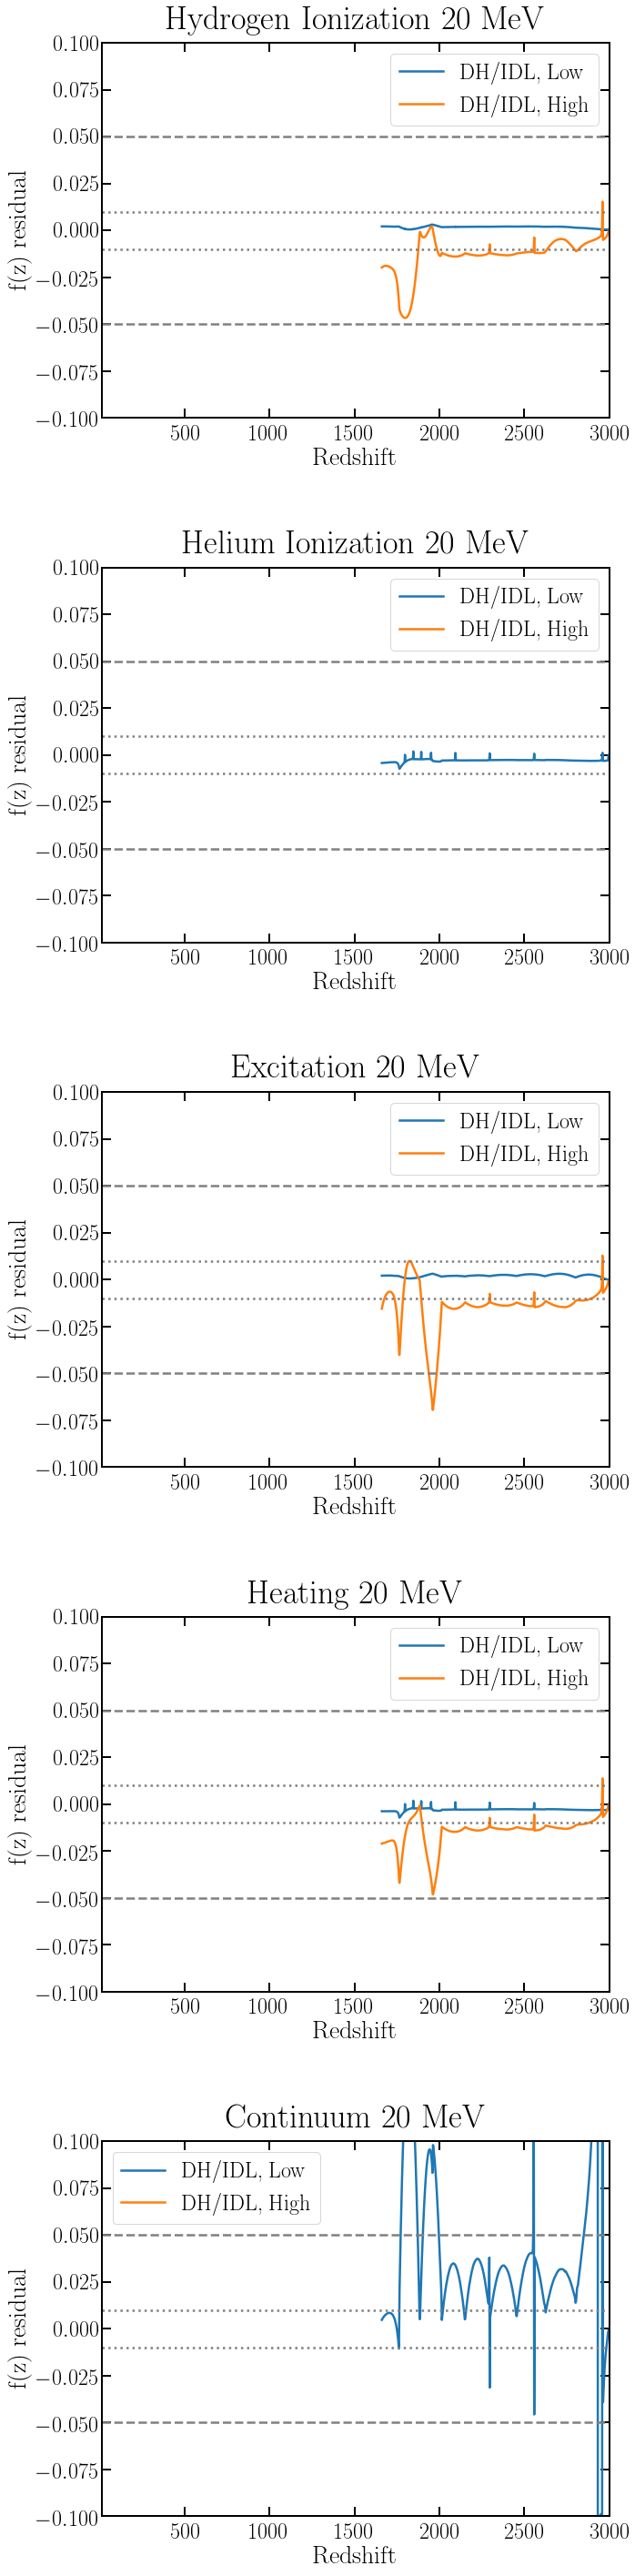

In [282]:
get_relComparison(' 20 MeV')

/home/gridgway/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide


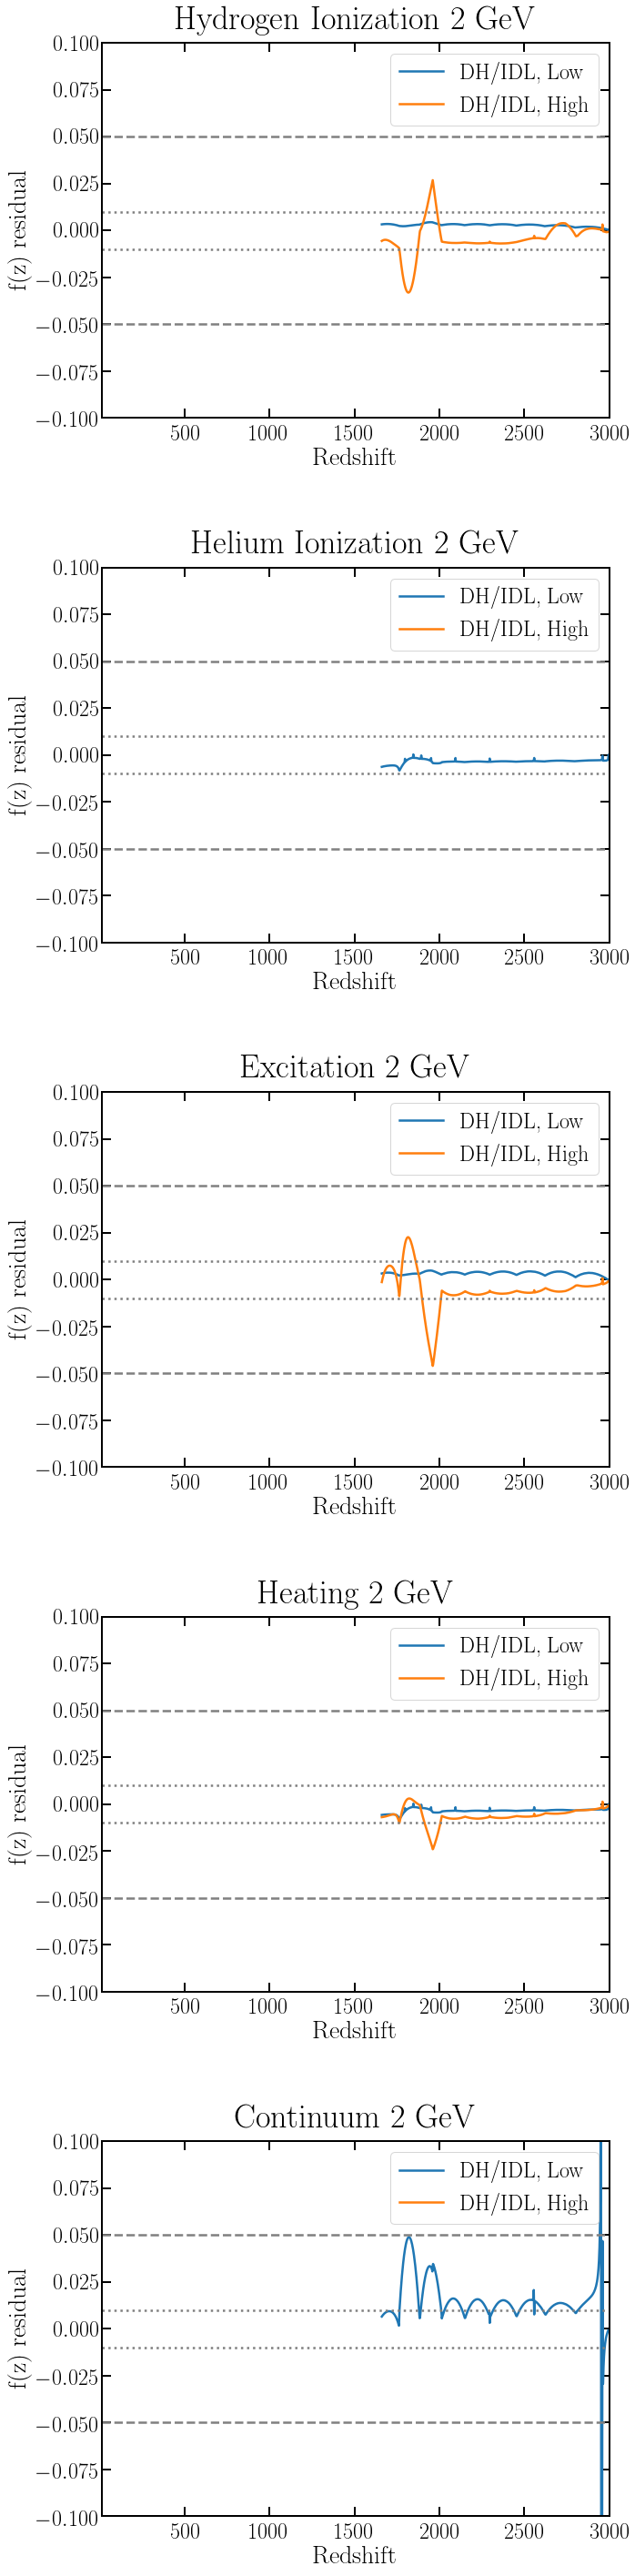

In [297]:
get_relComparison(' 2 GeV')

/home/gridgway/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide


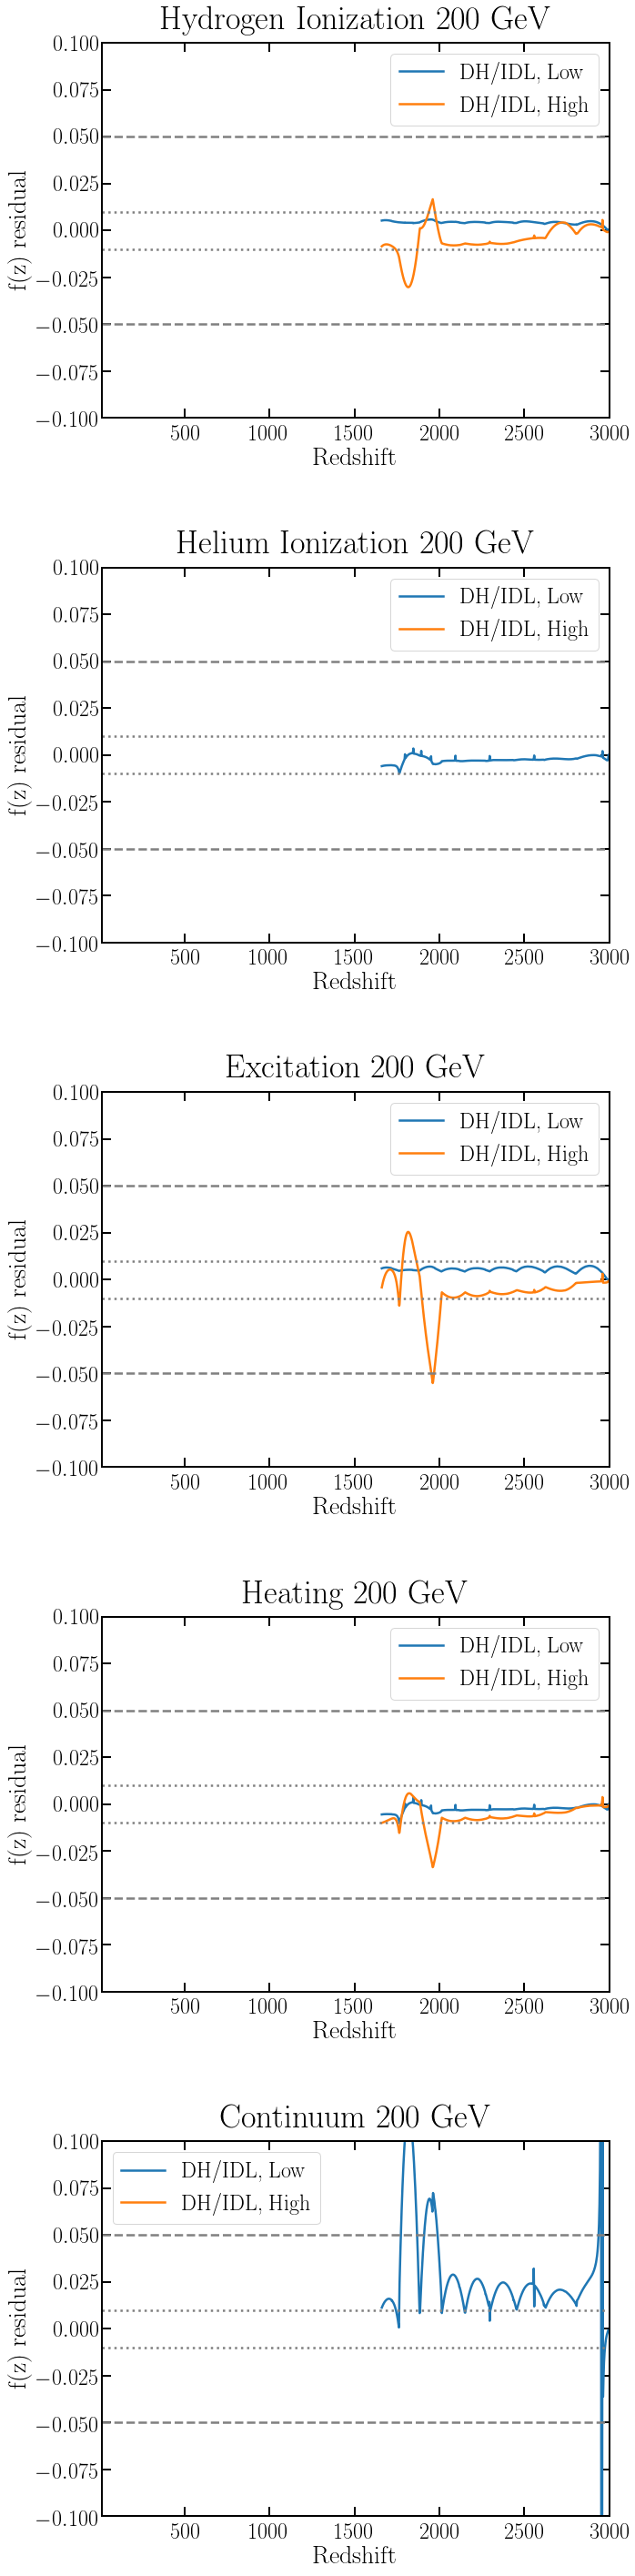

In [310]:
get_relComparison(' 200 GeV')

/home/gridgway/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


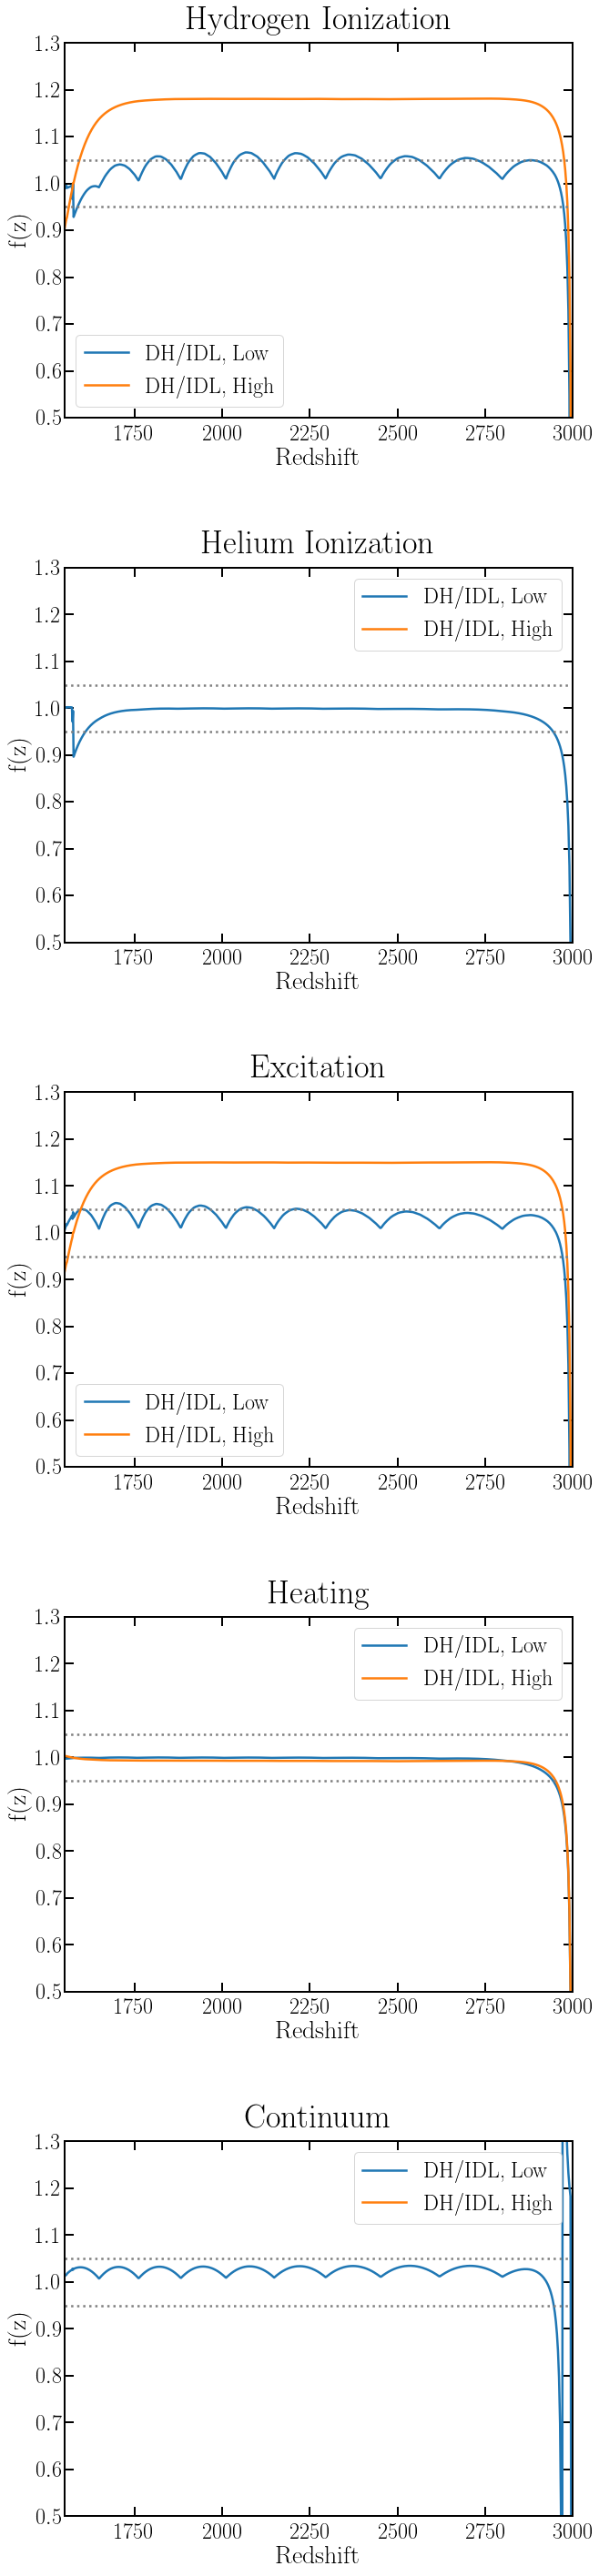

In [40]:
injE = photeng[photeng < mDM/2][-1]
    

f_H_ion_vec_math   = [f_H_ion(rs, injE) for rs in rs_vec[1:]]
f_He_ion_vec_math  = [f_He_ion(rs, injE) for rs in rs_vec[1:]]
f_exc_vec_math     = [f_H_exc(rs, injE) for rs in rs_vec[1:]]
f_heat_vec_math    = [f_heating(rs, injE) for rs in rs_vec[1:]]
f_cont_vec_math    = [f_cont(rs, injE) for rs in rs_vec[1:]]

f_vec_math = np.vstack([
    f_H_ion_vec_math, f_He_ion_vec_math, 
    f_exc_vec_math, f_heat_vec_math, 
    f_cont_vec_math
])


plt.figure(figsize=(10,50))
plt.subplots_adjust(hspace=.4)

for i in range(5):
    plt.subplot(5,1,i+1)
    ax = plt.gca()
#     ax.set_xscale('log')
#     ax.set_yscale('log')
    plt.xlabel('Redshift')
    plt.ylabel('f(z)')
    if i == 0:
        plt.title('Hydrogen Ionization')
    elif i == 1:
        plt.title('Helium Ionization')
    elif i == 2:
        plt.title('Excitation')
    elif i == 3:
        plt.title('Heating')
    elif i == 4:
        plt.title('Continuum')
        
    plt.axis([1550, 3000, 0.5, 1.3])
    plt.plot(rs_vec[1:],b_4e12[6][0][:,i]/f_idl_low[i,1:662], label='DH/IDL, Low')
    plt.plot(rs_vec[1:],b_4e12[6][1][:,i]/f_idl_high[i,1:662], label='DH/IDL, High')
    ax.axhline(0.95, color='gray', linestyle=':')
    ax.axhline(1.05, color='gray', linestyle=':')
    
    
    plt.legend()